# **Stock Portfolio Forecasting and Optimization on S&P500 Using Machine Learning and Search Methods**
<img src="images/pr.jpg" style="width:100%; height:100%;">

## **Abstract**  
Stock market forecasting and portfolio optimization are pivotal challenges in financial decision-making, driven by the volatility and complexity of markets like the S&P500. This project aims to develop an efficient system that predicts stock price trends and optimizes investment portfolios, leveraging historical S&P500 data from 2010 to 2023.  

The solution integrates traditional Machine Learning algorithms (e.g., Random Forest, SVM) for accurate stock price prediction. Furthermore, optimization techniques such as Monte Carlo simulations and genetic algorithms are employed to construct portfolios that maximize returns or minimize risks over a short-term investment horizon.  

By combining predictive analytics with optimization methodologies, this work provides insight for data-driven financial decision-making, promoting effective investment strategies. Ethical considerations and regulatory implications are also addressed, ensuring responsible and practical application in real-world financial contexts.

## **Introduction**
### **Context of the Problem**
The stock market is inherently volatile and complex, making it challenging for investors to forecast stock price trends and optimize investment decisions. Within the S&P500 index, the ability to predict stock movements and construct efficient portfolios is crucial for maximizing returns while managing risks. Traditional methods often fall short in addressing the rapid fluctuations and interdependencies inherent in financial markets, necessitating data-driven, adaptive solutions.

Machine Learning (ML) and Deep Learning (DL) have shown significant potential in addressing these challenges by analyzing large historical datasets, identifying patterns, and predicting trends with improved accuracy. Additionally, portfolio optimization techniques, such as Monte Carlo simulations and genetic algorithms, can help select investments that maximize returns or minimize risks based on forecasted trends. Combining these approaches can streamline decision-making, reduce human bias, and enhance financial performance.

### **Objective of the work**
This project aims to develop a robust framework for predicting stock price trends and optimizing investment portfolios within the S&P500 index. By leveraging ML algorithms models, the objective is to build accurate forecasting systems. These predictions will feed into optimization techniques to create well-balanced investment portfolios over a one-month horizon.

### **Structure of the work**
This notebook is structured as follows:
- Data Acquisition and EDA : We will collect historical price data for all S&P500 stocks from 2010 to January 2024 to build predictive models. Additionally, we will extract relevant financial indices such as moving averages, volatility, and trading volume, which can provide valuable insights into market trends. An Exploratory Data Analysis (EDA) will be conducted to study correlations, detect trends, and evaluate patterns within the data for the predictive modeling process.

- Stock Market Forecasting : This section focuses on developing multi-output forecasting models using traditional Machine Learning techniques such as Random Forest and Support Vector Machines (SVM). These models aim to predict the daily prices of all 500 stocks within the S&P500 index. The performance of each model will be compared using regression metrics such as Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE) to determine their effectiveness.

- Model Hyperparameter Tuning : After identifying the most promising models, we will perform hyperparameter tuning to enhance their predictive accuracy further. Techniques such as grid search and randomized search will be employed, targeting optimal configurations for regression metrics. 

- Stock Portfolio Optimization: Building on the forecasting outputs, we will employ advanced optimization techniques, including Monte Carlo simulations and genetic algorithms, to construct efficient investment portfolios. The Monte Carlo simulations will model various potential scenarios to evaluate risk and return distributions, while genetic algorithms will optimize portfolio allocation by iteratively evolving toward the most profitable or least risky configurations. These methods will account for constraints such as diversification, transaction costs, and risk tolerance.

- Discussion and Future Work :  Finally, we will analyze the results, discussing the strengths and limitations of our methodology. This section will provide insights into the practical applications of our approach and suggest potential refinements, such as incorporating alternative datasets (e.g., economic indicators or sentiment analysis) or exploring novel optimization algorithms. Future research directions will aim to enhance both predictive accuracy and portfolio optimization for real-world financial challenges.

### Libraries

In [2]:
import os
from datetime import datetime
import time

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Feature Selection
from sklearn.feature_selection import VarianceThreshold

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Decomposition
from sklearn.decomposition import IncrementalPCA, PCA

# Regressors
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, 
    ExtraTreesRegressor, BaggingRegressor, HistGradientBoostingRegressor
)
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, ARDRegression, 
    HuberRegressor, PassiveAggressiveRegressor, TheilSenRegressor, SGDRegressor, 
    PoissonRegressor, TweedieRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

# Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error,make_scorer
)

# Gradient Boosting Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV


# Utility functions
from importlib import reload
import utils
reload(utils)

from utils import (
    extract_sp500_companies, extract_stock, process_data, 
    join_stock_data, join_macro, join_technical_indicators,mean_positive_error,
    transformar_a_tensor_3d, crear_ventanas_temporales
)


import torch
from torch.utils.data import DataLoader, TensorDataset


In [27]:
# Importar y recargar utilidades
reload(utils)
from utils import copy_files

# Configuración de carpetas y parámetros
carpeta_origen = r'data/stocks'
carpeta_destino = r'data/probar'
num_archivos = 15
aleatorio = True

# Copiar archivos
copy_files(carpeta_origen, carpeta_destino, num_archivos, aleatorio)

# Cargar y procesar datos originales
reload(utils)

original_data     = join_stock_data(carpeta_destino)


null_cols = original_data.isnull().sum()
original_data['Date'] = pd.to_datetime(original_data['Date']).dt.tz_localize(None)
start = '2010-01-01'
end = '2024-01-31'

macro_data=join_macro(start,end)
raw_data = pd.merge(original_data, macro_data, on='Date', how='inner')

raw_data = raw_data.sort_values(by=[ 'Date']).reset_index(drop=True)
raw_data=raw_data[raw_data['Date'].notna()]



raw_data.bfill( inplace=True)
raw_data.ffill(inplace=True)


df = raw_data
# Iterar sobre todas las columnas menos 'Date'
for columna in df.columns:
    if columna not in ['Date','Volume'] :
        # Verificar valores no numéricos en la columna
        non_numeric_values = df[columna][~df[columna].apply(lambda x: isinstance(x, (int, float)))]
        # Convertir la columna a tipo numérico, forzando los errores a NaN
        df[columna] = pd.to_numeric(df[columna], errors='coerce')        


volume_columns = [col for col in df.columns if "Volume" in col]
for col in volume_columns: 
    df[col]=np.log1p(df[col])


df2=df.copy()

df2['Date']=pd.to_datetime(df2['Date'],format="ISO8601")



datos_tecnicos=join_technical_indicators(database=df2,folder =carpeta_destino,axis=True)



df2 = pd.merge(df2, datos_tecnicos, on='Date', how='outer')
df2 = df2.sort_values(by=[ 'Date']).reset_index(drop=True)

df2['day']          = df2['Date'].dt.day.astype('float64')
df2['month']        = df2['Date'].dt.month.astype('float64')
df2['year']         = df2['Date'].dt.year.astype('float64')
df2['day_of_week']  = df2['Date'].dt.dayofweek.astype('float64')



columnas_a_eliminar = [col for col in df2.columns if "Close_" in col and "AdjustedClose_" not in col]
df2 = df2.drop(columns=columnas_a_eliminar)

for columna in df2.columns:
    if columna not in ['Date','Volume'] :
        # Verificar valores no numéricos en la columna
        non_numeric_values = df2[columna][~df2[columna].apply(lambda x: isinstance(x, (int, float)))]
        # Convertir la columna a tipo numérico, forzando los errores a NaN
        df2[columna] = pd.to_numeric(df2[columna], errors='coerce')        


volume_columns = [col for col in df2.columns if "Volume" in col]
for col in volume_columns: 
    df2[col]=np.log1p(df2[col])

# Sustituir inf y -inf por 0 en todo el DataFrame
df2.replace([np.inf, -np.inf], 0, inplace=True)

# Filtrar y mostrar columnas con valores nulos en df2
null_columns_df2 = df2.isnull().sum()
print('Valores Nulos en Horizontal',null_columns_df2[null_columns_df2 > 0])

print('Duplicados: ',df2.duplicated().sum())


display(df2)


train=df2[df2['Date']<'2024-01-01']
test=df2[df2['Date']>='2024-01-01']




Cleared all files in destination folder: data/probar
Copied: IR.csv
Copied: ORCL.csv
Copied: D.csv
Copied: STT.csv
Copied: IFF.csv
Copied: MRNA.csv
Copied: WBA.csv
Copied: AMP.csv
Copied: IT.csv
Copied: LMT.csv
Copied: TMO.csv
Copied: OKE.csv
Copied: CVS.csv
Copied: LUV.csv
Copied: UPS.csv
Successfully copied 15 files to the folder: data/probar
Valores Nulos en Horizontal: Series([], dtype: int64)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Valores Nulos en Horizontal Series([], dtype: int64)
Duplicados:  0


,Date,AdjustedClose_AMP,High_AMP,Low_AMP,Open_AMP,Volume_AMP,AdjustedClose_CVS,High_CVS,Low_CVS,Open_CVS,...,MTM6_WBA,MTM12_WBA,ROC_WBA,SMI_WBA,WVAD_WBA,RSI_WBA,day,month,year,day_of_week
0,2010-01-04,28.856031,39.970001,38.919998,39.099998,2.748642,23.475386,33.060001,32.380001,32.430000,...,-0.015014,-0.022788,-2.278835,-1007.776389,-345.031221,44.046927,4.0,1.0,2010.0,0.0
1,2010-01-05,29.528963,40.810001,39.730000,39.770000,2.762460,23.382853,33.029999,32.660000,32.930000,...,-0.015014,-0.022788,-2.278835,-1007.776389,-437.378151,44.046927,5.0,1.0,2010.0,1.0
2,2010-01-06,29.941408,41.549999,40.860001,41.369999,2.778169,23.176430,32.980000,32.360001,32.450001,...,-0.015014,-0.022788,-2.278835,-1007.776389,-161.358129,44.046927,6.0,1.0,2010.0,2.0
3,2010-01-07,30.165705,41.950001,41.099998,41.299999,2.767058,24.030588,33.869999,32.560001,32.599998,...,-0.015014,-0.022788,-2.278835,-1007.776389,-413.684949,44.046927,7.0,1.0,2010.0,3.0
4,2010-01-08,30.274244,41.900002,41.340000,41.380001,2.721059,24.201429,34.410000,33.509998,33.669998,...,-0.015014,-0.022788,-2.278835,-1007.776389,-536.130604,44.046927,8.0,1.0,2010.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537,2024-01-24,384.191284,393.600006,388.989990,390.989990,2.657851,71.857964,76.599998,73.989998,75.989998,...,-0.021863,-0.105558,-10.555787,-16.309423,-54.324895,43.559936,24.0,1.0,2024.0,2.0
3538,2024-01-25,386.085358,402.649994,370.119995,370.119995,2.710677,69.727112,72.379997,70.190002,71.500000,...,0.042400,-0.098322,-9.832225,-13.575673,-18.192515,47.946681,25.0,1.0,2024.0,3.0
3539,2024-01-26,386.105072,395.450012,389.679993,393.429993,2.647362,70.705360,73.019997,71.959999,72.660004,...,0.031603,-0.098975,-9.897469,-12.250867,-50.825777,46.606938,26.0,1.0,2024.0,4.0
3540,2024-01-29,387.791931,393.309998,388.510010,390.130005,2.659601,71.170288,73.639999,72.860001,72.919998,...,0.032727,-0.079417,-7.941666,-10.003119,-56.891332,45.931431,29.0,1.0,2024.0,0.0


## **Data Acquisition**
As mentioned above, we will extract historical price data for all **current S&P500 stocks**. The list of stocks will be sourced from the S&P500 Wikipedia page, ensuring it reflects the most up-to-date composition of the index. Subsequently, we will utilize the Yahoo Finance API to retrieve the historical data for these stocks, covering the period from 2010 to January 2024. This dataset will include essential information such as daily opening and closing prices, trading volumes, and additional technical indicators. These data points will serve as the foundation for both the forecasting models and the portfolio optimization strategies.

### Extracting SP500 Companies

In [7]:
# URL de la página de Wikipedia
df = extract_sp500_companies()
companies = df['Símbolo']
df.head(5)




,Símbolo,Seguridad,Presentación ante la SEC,Sector GICS,Sub-industria GICS,Ubicación de la sede,Fecha de incorporación,Clave de índice central,Fundada
0,MMM,3M,reports,Industriales,Conglomerados Industriales,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industriales,Productos de Edificio,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Cuidado de Salud,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,A123,AbbVie,reports,Cuidado de Salud,Farmacéuticos,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,reports,Tecnología Informática,Consultoría Informática y Otros Servicios,"Dublin, Ireland",2011-07-06,1467373,1989


In [8]:


for stock in companies : 
    raw_stock_data = extract_stock(stock)
    if raw_stock_data is not None : 
        raw_stock_data.to_csv(f"data/raw_stocks/{stock}.csv")
        stock_data = process_data(f"data/raw_stocks/{stock}.csv")
        stock_data.to_csv(f"data/stocks/{stock}.csv")
    
stock_data.head()
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['A123']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

No data found for A123.



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for ATVI.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for ABC.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for BRK.B.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for CDAY.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for DISH.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for RE.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FRC']: YFTzM

No data found for FRC.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FLT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for FLT.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for PEAK.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

No data found for PKI.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PXD']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for PXD.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for SBNY.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SIVB']: YFPr

No data found for SIVB.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for WRK.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,AdjustedClose,Close,High,Low,Open,Volume
0,2013-02-01 00:00:00+00:00,28.409882,31.010000,31.74,30.469999,31.50,66789100
1,2013-02-04 00:00:00+00:00,28.419044,31.020000,31.99,30.760000,31.09,7695400
2,2013-02-05 00:00:00+00:00,28.437363,31.040001,31.98,30.850000,31.25,5013200
3,2013-02-06 00:00:00+00:00,28.428202,31.030001,31.43,30.750000,30.98,2126100
4,2013-02-07 00:00:00+00:00,29.316872,32.000000,32.73,31.000000,31.00,3800800


In [9]:

print(f"Raw Files Retrieved : {len(os.listdir('data/raw_stocks/'))}, Processed Files : {len(os.listdir('data/stocks/'))}")
raw_folder = "data/raw_stocks/"
raw_files = [os.path.splitext(file)[0] for file in os.listdir(raw_folder) if file.endswith('.csv')]
missing_companies = [company for company in companies if company not in raw_files]
print(f"Companies without data : {missing_companies}")


Raw Files Retrieved : 500, Processed Files : 500
Companies without data : ['A123', 'ATVI', 'ABC', 'BRK.B', 'CDAY', 'DISH', 'RE', 'FRC', 'FLT', 'PEAK', 'PKI', 'PXD', 'SBNY', 'SIVB', 'WRK']


A total of 15 companies have been identified as requiring the use of alternative tickers, as the existing tickers are no longer available on the Yahoo Finance website. The following challenges were encountered:

- Berkshire Hathaway operates two distinct types of stocks, one targeting high-net-worth investors and another designed for those with more limited financial resources. Nevertheless, both types of stocks have been included in the dataset due to the critical importance of both stock classes to the company's financial structure.

- In contrast, First Republic Bank ceased operations in May 2023 due to a banking crisis, and thus, it will not be included in the dataset. Similarly, SVB Financial Group experienced a banking crisis and was removed from the index in March 2023, so it will also be excluded. 

- EchoStar Corporation acquired DISH Network Corporation on December 31, 2023. Following this merger, DISH shares were converted into EchoStar shares, and the "DISH" ticker symbol was removed from S&P500 listings. 

- Activision Blizzard 

In [70]:
reload(utils)
from utils import process_data
missing_companies_ticker=['ABBV','AIY.DE','COR','BRKA.VI','BRKB.VI','DAY','EG','CPAY','DOC','VST','BG','SWR.L']
for missing_stock in missing_companies_ticker: 
    raw_stock_data = extract_stock(missing_stock)
    if raw_stock_data is not None : 
        raw_stock_data.to_csv(f"data/raw_stocks/{missing_stock}.csv")
        stock_data = process_data(f"data/raw_stocks/{missing_stock}.csv")
        stock_data.to_csv(f"data/stocks/{missing_stock}.csv")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### **Merging Stock data and Macroeconomic data**

After obtaining individual CSV files containing data for each stock, our next step was to construct a unified, comprehensive dataset. Initially, we considered an approach where each company’s data would be arranged in contiguous blocks, with repeated date entries for each firm and only six columns : *Date*, *Close*, *AdjustedClose*, *Open*, *High*, and *Volume* in the original_data dataframe. While this method would keep the dataset structure relatively simple, we identified several drawbacks. First, this vertical stacking of time-series data for each company could prevent the model from capturing important **inter-company relationships**. Moreover, implementing such an arrangement would complicate the programming process and significantly increase computational demands.

Example of the vertical stacking : 

| Date       | Close  | AdjustedClose | Open   | High   | Volume   | Company |
|------------|---------|--------------|--------|--------|----------|---------|
| 2020-01-01 | 300.35 | 300.32       | 299.80 | 303.00 | 31,000   | AAPL    |
| 2020-01-02 | 302.20 | 302.18       | 301.50 | 305.10 | 25,500   | AAPL    |
| 2020-01-03 | 298.90 | 298.87       | 297.30 | 301.00 | 28,000   | AAPL    |
| ...        | ...    | ...          | ...    | ...    | ...      | AAPL    |
| 2020-01-01 | 150.10 | 150.08       | 149.70 | 151.50 | 20,000   | MSFT    |
| 2020-01-02 | 152.50 | 152.45       | 151.90 | 153.00 | 22,000   | MSFT    |
| 2020-01-03 | 149.90 | 149.85       | 149.00 | 150.80 | 18,500   | MSFT    |
| ...        | ...    | ...          | ...    | ...    | ...      | MSFT    |


To address these challenges, we opted to merge the CSV files for each stock **horizontally**, aligning their data by dates. In other words, we combined the datasets as additional columns rather than stacking them by rows. This horizontal integration enables the model to simultaneously analyze the time-series behavior of multiple stocks, thereby facilitating the discovery of cross-company correlations and interdependencies. By leveraging a richer information structure, the model is better positioned to uncover complex patterns and improve predictive accuracy. Ultimately, this approach not only enhances the model’s explanatory power but also reduces the computational overhead associated with more convoluted dataset configurations. 

#### **Date range challenge**

During the merge process, a challenge arose in relation to the discrepancies in the date ranges of individual stock data files. While most stocks shared a common set of trading dates, certain exceptions introduced inconsistencies. For instance, the stock *AIV.DE*, associated with Activision Blizzard and listed on a European exchange, includes observations on days that are U.S. market holidays, such as July 4th, when no trading occurs in the United States. As a result, *AIV.DE* featured dates absent from the majority of our U.S.-centric dataset.

To maintain a coherent temporal framework and minimize the introduction of missing values, we opted to exclude these additional European trading dates from the *AIV.DE* series. Specifically, we aligned all stocks to the date range with the most frequent number of observations : **3542** dates ,effectively harmonizing the dataset’s temporal dimension. This strategy ensures that the dataset remains consistent across all constituent stocks, enabling more straightforward modeling and analysis of time-series relationships within the S&P 500 context.

Furthermore, not all stocks commenced trading on the same initial date. To address potential gaps at the start of each series gaps that would otherwise generate numerous NaN entries we employed a data-filling technique. For dates lacking stock-specific information, we replaced missing values with **zeros**. While this approach introduces a neutral placeholder rather than an imputed economic value, it serves to preserve the shape and integrity of the dataset. This, in turn, facilitates subsequent modeling efforts by ensuring uniform input dimensions, reducing the need for complex imputations, and allowing the learning algorithm to focus on detecting meaningful economic and market-driven patterns rather than being confounded by irregular data structures.

Mode: 3542
The file with the highest number of dates is: AIY.DE with 3578 dates.
The most common start date is: 2010-01-04 00:00:00+00:00
The most common end date is: 2024-01-30 00:00:00+00:00
Dates present in the max file (AIY.DE) but not in the mode file (3542 dates):
{Timestamp('2018-05-28 00:00:00+0000', tz='UTC'), Timestamp('2016-07-04 00:00:00+0000', tz='UTC'), Timestamp('2012-10-29 00:00:00+0000', tz='UTC'), Timestamp('2021-01-18 00:00:00+0000', tz='UTC'), Timestamp('2020-07-03 00:00:00+0000', tz='UTC'), Timestamp('2012-01-16 00:00:00+0000', tz='UTC'), Timestamp('2013-01-21 00:00:00+0000', tz='UTC'), Timestamp('2023-07-04 00:00:00+0000', tz='UTC'), Timestamp('2020-11-26 00:00:00+0000', tz='UTC'), Timestamp('2020-05-25 00:00:00+0000', tz='UTC'), Timestamp('2019-05-27 00:00:00+0000', tz='UTC'), Timestamp('2018-09-03 00:00:00+0000', tz='UTC'), Timestamp('2021-07-05 00:00:00+0000', tz='UTC'), Timestamp('2015-09-07 00:00:00+0000', tz='UTC'), Timestamp('2018-01-15 00:00:00+0000', tz='

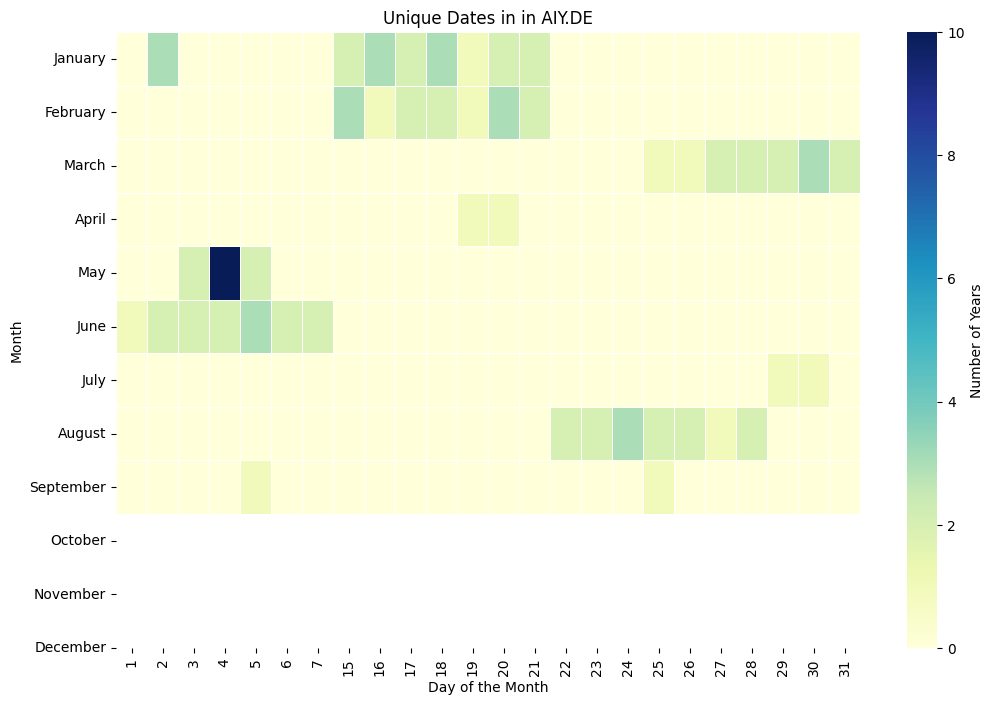

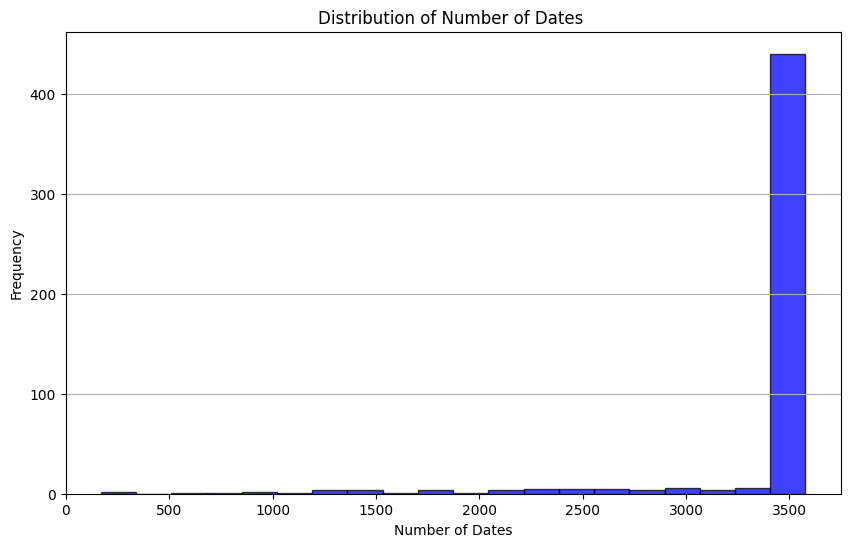

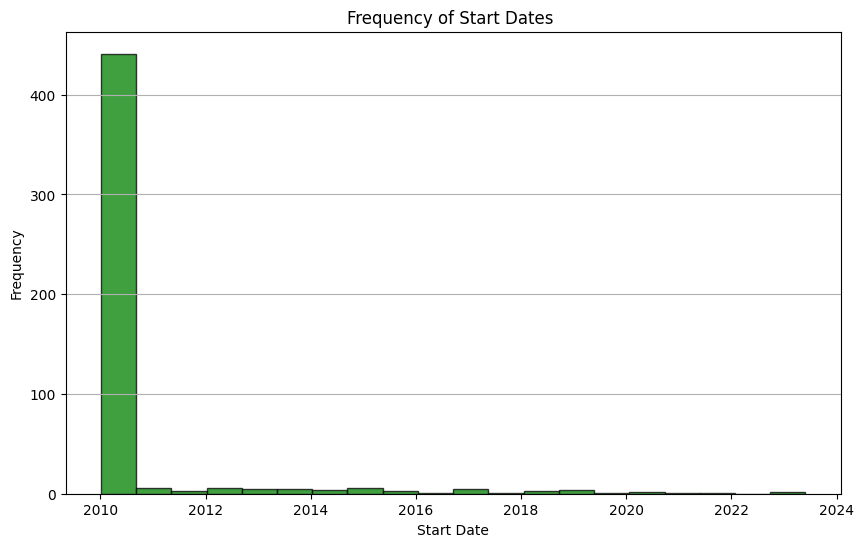

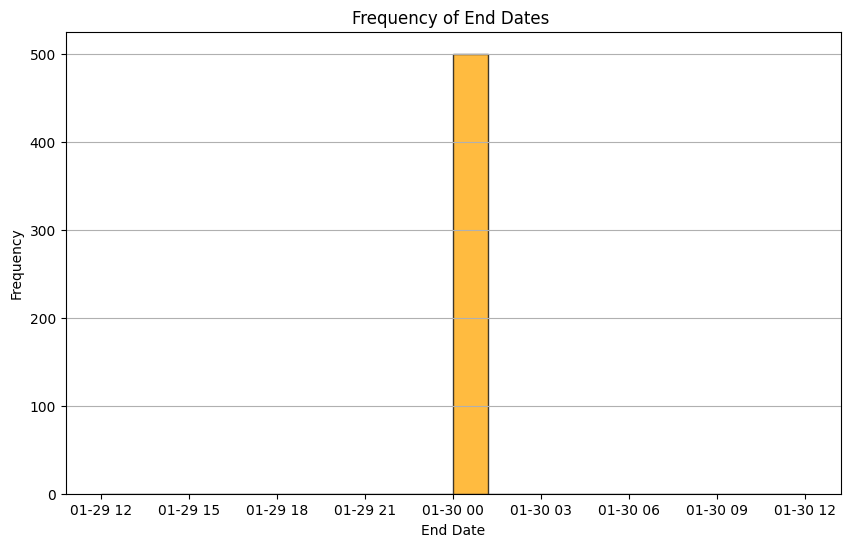

In [63]:
reload(utils)
from utils import join_stock_data,analyze_date_ranges
   
analyze_date_ranges()


Mode: 3542
The file with the highest number of dates is: AIY.DE with 3578 dates.
The most common start date is: 2010-01-04 00:00:00+00:00
Dates present in the max file (AIY.DE) but not in the mode file (3542 dates):
{Timestamp('2018-05-28 00:00:00+0000', tz='UTC'), Timestamp('2016-07-04 00:00:00+0000', tz='UTC'), Timestamp('2012-10-29 00:00:00+0000', tz='UTC'), Timestamp('2021-01-18 00:00:00+0000', tz='UTC'), Timestamp('2020-07-03 00:00:00+0000', tz='UTC'), Timestamp('2012-01-16 00:00:00+0000', tz='UTC'), Timestamp('2013-01-21 00:00:00+0000', tz='UTC'), Timestamp('2023-07-04 00:00:00+0000', tz='UTC'), Timestamp('2020-11-26 00:00:00+0000', tz='UTC'), Timestamp('2020-05-25 00:00:00+0000', tz='UTC'), Timestamp('2019-05-27 00:00:00+0000', tz='UTC'), Timestamp('2018-09-03 00:00:00+0000', tz='UTC'), Timestamp('2021-07-05 00:00:00+0000', tz='UTC'), Timestamp('2015-09-07 00:00:00+0000', tz='UTC'), Timestamp('2018-01-15 00:00:00+0000', tz='UTC'), Timestamp('2022-09-05 00:00:00+0000', tz='UTC'),

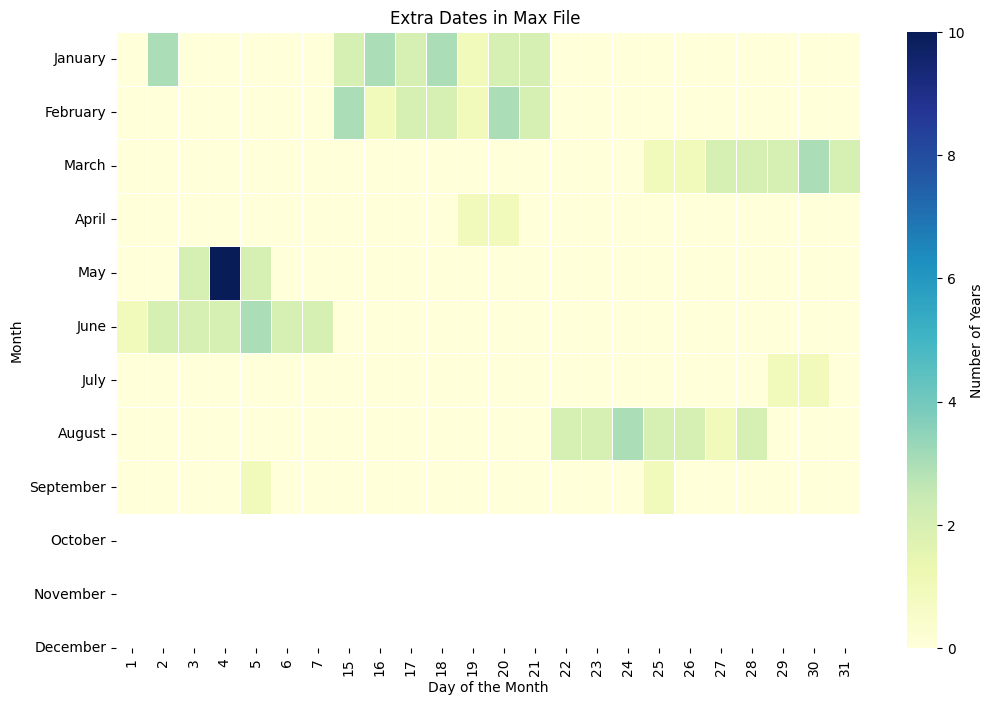

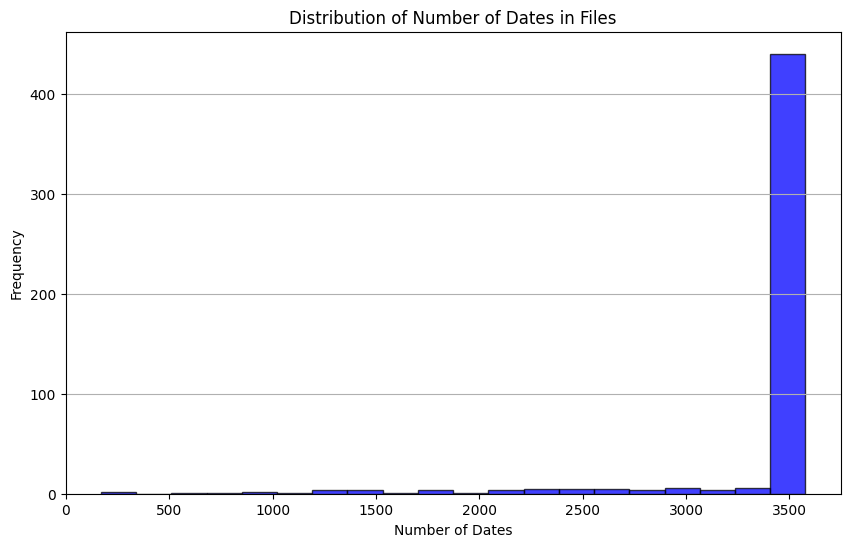

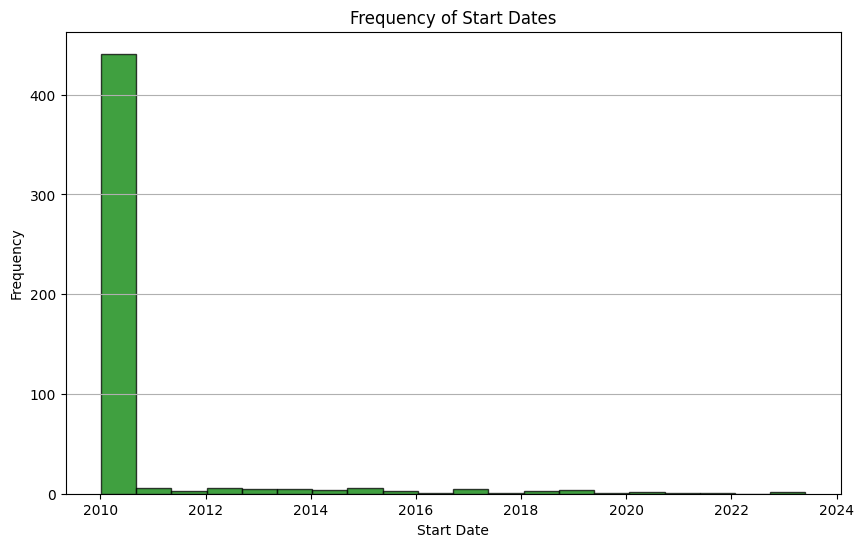

Valores Nulos en Horizontal: Series([], dtype: int64)
Null values horizontally Series([], dtype: int64)


,Date,AdjustedClose_A,Close_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,Close_AAL,High_AAL,...,High_ZION,Low_ZION,Open_ZION,Volume_ZION,AdjustedClose_ZTS,Close_ZTS,High_ZTS,Low_ZTS,Open_ZTS,Volume_ZTS
0,2010-01-04,20.053032,22.389128,22.625179,22.267525,22.453505,3815561,4.496876,4.77,4.94,...,13.370000,12.880000,12.940000,3974600,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2010-01-05,19.835201,22.145924,22.331903,22.002861,22.324751,4186031,5.005958,5.31,5.37,...,13.830000,13.230000,13.280000,5605500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,2010-01-06,19.764729,22.067240,22.174536,22.002861,22.067240,3243779,4.798555,5.09,5.38,...,15.010000,13.660000,13.670000,12615200,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,2010-01-07,19.739101,22.038628,22.045780,21.816881,22.017166,3095172,4.939965,5.24,5.43,...,17.000000,14.950000,14.970000,24716800,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,2010-01-08,19.732687,22.031473,22.067240,21.745352,21.917025,3733918,4.845691,5.14,5.43,...,16.660000,15.520000,16.190001,6903000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537,2024-01-24,129.123932,129.779999,132.800003,129.429993,132.410004,1141900,13.930000,13.93,14.18,...,44.930000,43.250000,43.540001,3480100,184.663101,186.070007,189.699997,185.929993,188.809998,1837700.0
3538,2024-01-25,129.223419,129.880005,131.429993,129.429993,131.110001,1120900,15.360000,15.36,15.46,...,45.330002,43.630001,44.790001,2358000,185.903656,187.320007,187.529999,185.309998,185.529999,2530600.0
3539,2024-01-26,130.327835,130.990005,134.229996,130.639999,133.710007,1319800,15.130000,15.13,15.84,...,44.860001,43.959999,44.500000,1504900,190.071899,191.520004,192.880005,188.970001,189.210007,1840200.0
3540,2024-01-29,132.158524,132.830002,132.899994,131.279999,131.750000,1407200,14.940000,14.94,15.39,...,44.990002,43.770000,43.970001,2051600,191.302521,192.759995,193.000000,189.960007,191.360001,1669900.0


In [57]:
import utils 

original_data     = join_stock_data(r"data/stocks")


null_cols = original_data.isnull().sum()
print('Null values horizontally',null_cols[null_cols > 0])

original_data['Date'] = pd.to_datetime(original_data['Date']).dt.tz_localize(None)


display(original_data)




### Enriching the Dataset with Macroeconomic and Financial Indicators

After consolidating all individual stock data into a single dataset, we applied the `join_macro` function to enrich our database with a comprehensive array of macroeconomic and financial indicators. Incorporating this expanded feature set provides the model with a broader economic context, potentially enhancing its predictive accuracy and explanatory power. By capturing both domestic and international market conditions, the model can better discern complex interdependencies between global economic factors and the performance of the constituent stocks in the S&P 500.


Below we summarize the key variables added, grouped into two categories: **U.S. Macroeconomic Indicators** and **Other Global Market Indices and Futures**. These additional variables offer insights into overall economic health, monetary and fiscal policy, labor market conditions, trade dynamics, price stability, and liquidity. Integrating such diverse data sources allows the model to uncover cross-market correlations, thereby improving its ability to identify nuanced patterns that may influence stock price movements.

U.S. Macroeconomic Indicators:

- **GDP** (Gross Domestic Product: Measures the total value of goods and services produced in the U.S., reflecting overall economic health.

- **UNRATE** (Unemployment Rate): Indicates labor market conditions and potential demand-side pressures.

- **CPIAUCSL** (Consumer Price Index for All Urban Consumers): Tracks consumer inflation, influencing purchasing power and monetary policy responses.

- **PAYEMS** (Nonfarm Payroll Employment): A key labor market metric that signals economic momentum and consumer demand.
- **FEDFUNDS** (Federal Funds Rate): Central bank policy rate affecting the cost of borrowing and liquidity conditions.
- **DGS10** (10-Year Treasury Yield): A long-term interest rate proxy, guiding expectations for inflation, borrowing costs, and economic growth.
- **M1SL / M2SL** (Money Supply Measures): Indicators of liquidity and credit availability in the financial system.
- **^GSPC (S&P 500 Index):** Benchmark U.S. equity index, forming the core focus of our study.
- **INDPRO (Industrial Production Index):** Reflects the output of the manufacturing, mining, and utility sectors.
- **RSAFS (Retail and Food Services Sales):** Gauges consumer spending behavior, an essential driver of economic activity.
- **EXCAUS (USD/CAD Exchange Rate):** Offers insights into trade competitiveness and cross-border capital flows.
- **BOPGSTB (Balance of Trade in Goods and Services):** Highlights the net trade position, influencing external demand and currency valuation.
- **GFDEBTN (Federal Government Debt) & FGEXPND (Federal Government Expenditures):** Indicate fiscal policy stance and public sector influence on economic conditions.
- **PCEPI (Personal Consumption Expenditures Price Index):** A key inflation measure guiding monetary policy decision-making.
- **PPIACO (Producer Price Index):** Anticipates consumer price trends by reflecting upstream cost pressures.

 Other Indices and Futures:

- **^IXIC (NASDAQ) & ^RUT (Russell 2000):** Provide additional perspectives on U.S. equity markets, focusing on technology and smaller-cap firms, respectively.

- **^STOXX50E (EURO STOXX 50) & ^FTSE (FTSE 100):** Offer insights into European and U.K. market conditions, facilitating cross-regional comparisons.
- **CL=F, SI=F, GC=F, NG=F, ZC=F, HO=F (Crude Oil, Silver, Gold, Natural Gas, Corn, Heating Oil Futures):** Represent commodity market dynamics, essential for understanding supply-side constraints and inflationary pressures.
- **^HSI (Hang Seng):** Extends market coverage to Asia, capturing the influence of Chinese and Hong Kong markets.
- **EURUSD=X (Euro-U.S. Dollar Exchange Rate):** Reflects a key global currency pair, influencing international trade and capital flows.
- **BTC-USD (Bitcoin Price):** Provides insight into the cryptocurrency market, offering a proxy for risk sentiment and alternative asset demand.


By integrating this expanded set of macroeconomic and financial features, the model gains a richer, more holistic perspective on the economic environment. This, in turn, enables it to identify previously obscured patterns, improve its predictive robustness, and deliver more nuanced insights into the forces shaping the performance of the S&P 500 stocks.


In [58]:
start = '2010-01-01'
end = '2024-01-31'

macro_data=join_macro(start,end)
raw_data = pd.merge(original_data, macro_data, on='Date', how='inner')

raw_data = raw_data.sort_values(by=[ 'Date']).reset_index(drop=True)
raw_data=raw_data[raw_data['Date'].notna()]



raw_data.bfill( inplace=True)
raw_data.ffill(inplace=True)


df = raw_data
# Iterar sobre todas las columnas menos 'Date'
for columna in df.columns:
    if columna not in ['Date','Volume'] :
        # Verificar valores no numéricos en la columna
        non_numeric_values = df[columna][~df[columna].apply(lambda x: isinstance(x, (int, float)))]
        # Convertir la columna a tipo numérico, forzando los errores a NaN
        df[columna] = pd.to_numeric(df[columna], errors='coerce')        


volume_columns = [col for col in df.columns if "Volume" in col]
for col in volume_columns: 
    df[col]=np.log1p(df[col])

display(df)
print('Size of Horizontal Structure',df.shape)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Date,AdjustedClose_A,Close_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,Close_AAL,High_AAL,...,^FTSE,CL=F,SI=F,GC=F,^HSI,NG=F,ZC=F,EURUSD=X,BTC-USD,HO=F
0,2010-01-04,20.053032,22.389128,22.625179,22.267525,22.453505,15.154599,4.496876,4.77,4.94,...,5500.299805,81.510002,17.440001,1117.699951,21823.279297,5.884,418.50,1.442398,457.334015,2.1905
1,2010-01-05,19.835201,22.145924,22.331903,22.002861,22.324751,15.247264,5.005958,5.31,5.37,...,5522.500000,81.769997,17.781000,1118.099976,22279.580078,5.637,418.75,1.436596,457.334015,2.1941
2,2010-01-06,19.764729,22.067240,22.174536,22.002861,22.067240,14.992250,4.798555,5.09,5.38,...,5530.000000,83.180000,18.163000,1135.900024,22416.669922,6.009,421.75,1.440403,457.334015,2.2032
3,2010-01-07,19.739101,22.038628,22.045780,21.816881,22.017166,14.945354,4.939965,5.24,5.43,...,5526.700195,82.660004,18.333000,1133.099976,22269.449219,5.806,417.50,1.431803,457.334015,2.1836
4,2010-01-08,19.732687,22.031473,22.067240,21.745352,21.917025,15.132969,4.845691,5.14,5.43,...,5534.200195,82.750000,18.458000,1138.199951,22296.750000,5.749,423.00,1.441109,457.334015,2.2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537,2024-01-24,129.123932,129.779999,132.800003,129.429993,132.410004,13.948205,13.930000,13.93,14.18,...,7527.700195,75.089996,22.754999,2013.900024,15899.870117,2.641,452.25,1.085788,40077.074219,2.6818
3538,2024-01-25,129.223419,129.880005,131.429993,129.429993,131.110001,13.929643,15.360000,15.36,15.46,...,7529.700195,77.360001,22.808001,2016.900024,16211.959961,2.571,451.75,1.088175,39933.808594,2.7954
3539,2024-01-26,130.327835,130.990005,134.229996,130.639999,133.710007,14.092992,15.130000,15.13,15.84,...,7635.100098,78.010002,22.754999,2016.800049,15952.230469,2.712,446.25,1.084705,41816.871094,2.8434
3540,2024-01-29,132.158524,132.830002,132.899994,131.279999,131.750000,14.157113,14.940000,14.94,15.39,...,7632.700195,76.779999,23.138000,2025.199951,16077.240234,2.490,440.25,1.084352,43288.246094,2.8339


Size of Horizontal Structure (3542, 3031)


### **Difference between Adjusted Close and Close** :

The Close price of a stock represents the last trading price recorded at the end of the market session for a specific date. However, it does not account for corporate events such as dividends, stock splits, mergers, acquisitions, spin-offs, or other actions that can alter the company’s capital structure and historical price records. In contrast, the Adjusted Close price systematically incorporates these adjustments, enabling a more consistent and comparable view of the stock's value over time.

By using the Adjusted Close price, the time series becomes free from arbitrary discontinuities caused by structural changes to the stock. For instance, in the case of a 2:1 stock split, the nominal price is halved without affecting the company's fundamental value. This adjustment ensures that historical analysis provides a more accurate representation of the stock's underlying performance, eliminating artificial fluctuations and facilitating the identification of genuine trends.

Machine learning and deep learning models often rely on stable and consistent patterns within time series data to make reliable predictions. The use of Adjusted Close prices reduces the "noise" introduced by corporate events that do not reflect changes in the stock's intrinsic economic value. This leads to a more accurate extraction of meaningful market signals. Such adjustments are particularly critical for models with medium- or long-term prediction horizons, as they enhance the reliability and interpretability of the model’s output by focusing on real trends rather than transient, non-economic artifacts in the data.



c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\Proyect2_LABIACD\visualizations.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_mean = df_period['DifPercent'].mean()


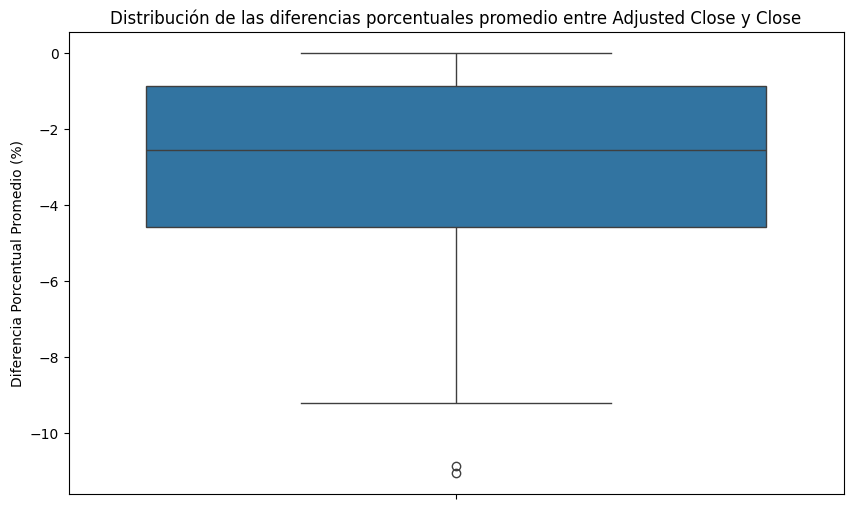

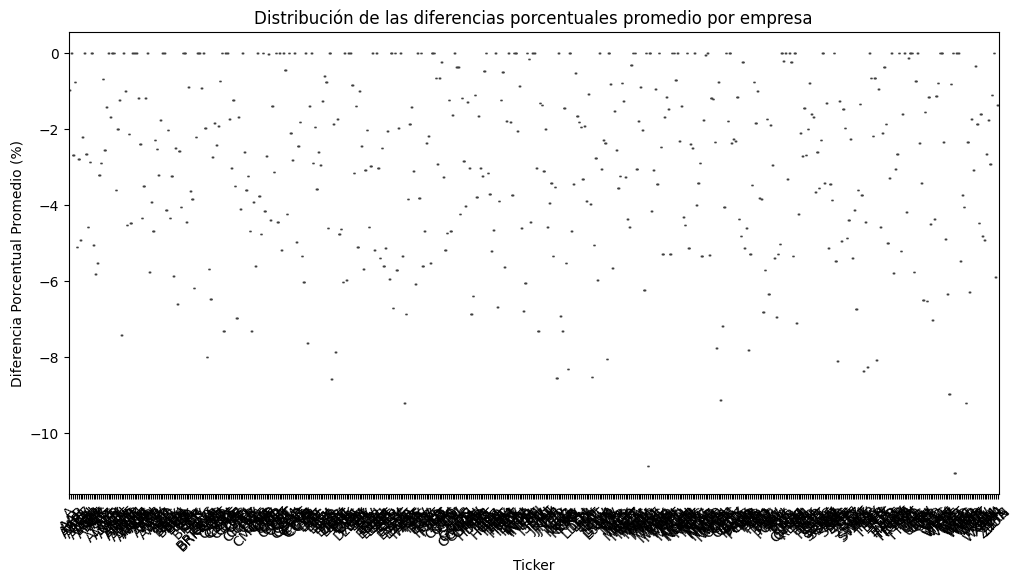

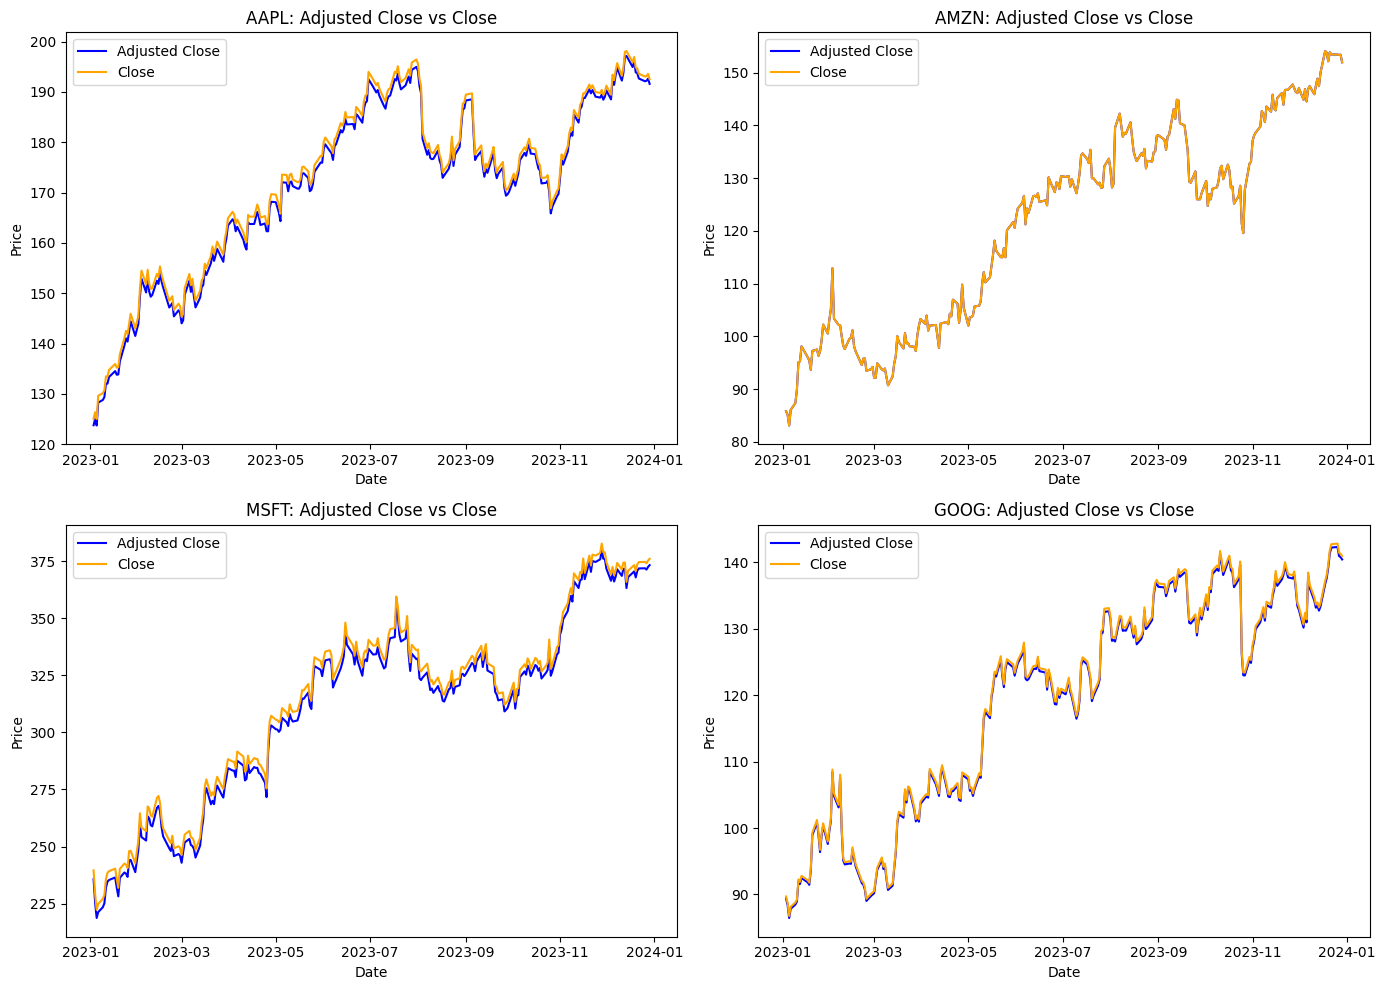

In [76]:
import visualizations
reload (visualizations)
from visualizations import represent_adj_close
start='2023-01-01'
end='2023-12-31'

represent_adj_close(df,start,end)

### **Obtaining Technical Indicators**

Tras añadir los datos financieros y macroeconómicos, vamos a obtener una serie de indicadores técincos para los datos de los stock a través de la librería **ta**, la cual se trata de una librería para realizar análisis de series temporales. Gracias a esta librería hemos seleccionado una serie de características tomando como referencia el siguiente paper [Bao W, Yue J, Rao Y. A deep learning framework for financial time series using stacked autoencoders and long-short term memory.](https://pubmed.ncbi.nlm.nih.gov/28708865/). Los indicadores técnicos que hemos seleccionado han sido los siguientes : 



Subscripts $t$ indicate the current time step, and $n$ denotes the chosen window length.

1. **Moving Average Convergence Divergence (MACD)**  
MACD is a momentum-based trend indicator derived from the difference between two Exponential Moving Averages (EMAs) of the closing price. It helps identify potential trend reversals and measure the strength of current market momentum
$$
\text{MACD} = \text{EMA}(\text{Close}, n_{\text{short}}) - \text{EMA}(\text{Close}, n_{\text{long}})
$$

- Common parameters: $n_{\text{short}} = 12$, $n_{\text{long}} = 26$.

2. **Commodity Channel Index (CCI)**  
The CCI measures the deviation of a security’s price from its average price level, indicating whether it is overpriced or underpriced relative to its typical price range. It aids in identifying cyclical trends and potential overbought/oversold market conditions.

$$
\text{Typical Price} = \frac{\text{High} + \text{Low} + \text{Close}}{3}
$$

$$
\text{CCI} = \frac{\text{Typical Price} - \text{SMA}(\text{Typical Price}, n)}{0.015 \cdot \text{Mean Deviation}}
$$

3. **Average True Range (ATR)**  
ATR measures market volatility without indicating price direction. It estimates the degree of price movement and is commonly used in risk management.

$$
\text{TR}_t = \max\{\text{High}_t - \text{Low}_t, |\text{High}_t - \text{Close}_{t-1}|, |\text{Low}_t - \text{Close}_{t-1}|\}
$$

$$
\text{ATR} = \text{MA}(\text{TR}, n)
$$

- Common window: $n = 14$.

4. **Bollinger Bands (BOLL_upper, BOLL_lower)**  
Bollinger Bands consist of a moving average (middle band) of the closing price, and two bands set at a chosen number of standard deviations above and below the mean. They dynamically expand and contract with market volatility, helping identify potential price breakouts.
$$
\text{BOLL\_middle} = \text{MA}(\text{Close}, n)
$$

$$
\text{BOLL\_upper} = \text{BOLL\_middle} + k \cdot \sigma(\text{Close}, n)
$$

$$
\text{BOLL\_lower} = \text{BOLL\_middle} - k \cdot \sigma(\text{Close}, n)
$$

- Common parameters: $n = 20$, $k = 2$.

5. **Exponential Moving Average (EMA20)**  
The EMA assigns a higher weight to recent data points, making it more responsive than a Simple Moving Average.

$$
\text{EMA}(\text{Close}, n) = \alpha \cdot \text{Close}_t + (1 - \alpha) \cdot \text{EMA}(\text{Close}, n)_{t-1}
$$

$$
\alpha = \frac{2}{n+1}
$$

- Common window: $n = 20$.

6. **Simple Moving Averages (MA5, MA10)**  
Simple Moving Averages smooth out short-term fluctuations by averaging a series of closing prices over the last $n$ periods.

$$
\text{MA}_n = \frac{1}{n}\sum_{i=0}^{n-1} \text{Close}_{t-i}
$$

- For MA5 and MA10, $n = 5$ and $n = 10$, respectively.

7. **Momentum (MTM6, MTM12)**  
Momentum measures the rate of price change over a defined period, indicating whether prices are accelerating or decelerating.

$$
\text{MTM}_n = \frac{\text{Close}_t - \text{Close}_{t-n}}{\text{Close}_{t-n}}
$$

- For MTM6 and MTM12, $n = 6$ and $n = 12$, respectively.

8. **Rate of Change (ROC)**  
ROC calculates the percentage change in a security’s closing price over a specified time interval.

$$
\text{ROC} = \frac{\text{Close}_t - \text{Close}_{t-n}}{\text{Close}_{t-n}} \times 100
$$

9. **Stochastic Momentum Index (SMI)**  
The SMI refines the traditional Stochastic Oscillator by centering the price relative to the midpoint of the highest high and lowest low over a given period.

$$
\text{SMI} = \frac{\text{Close}_t - \frac{\text{Highest High} + \text{Lowest Low}}{2}}{(\text{Highest High} - \text{Lowest Low})/2} \times 100
$$

10. **Williams Volume Accumulation/Distribution (WVAD)**  
WVAD integrates both price movement and trading volume to evaluate whether price trends are supported by sufficient market participation.

$$
\text{WVAD} = \frac{\text{Close}_t - \text{Open}_t}{\text{High}_t - \text{Low}_t} \times \text{Volume}_t
$$

11. **Relative Strength Index (RSI)**  
RSI compares recent price gains versus losses over a chosen period, identifying overbought (RSI > 70) or oversold (RSI < 30) conditions.

$$
\text{RSI} = 100 - \frac{100}{1 + RS}
$$

$$
RS = \frac{\text{Average Gain}}{\text{Average Loss}}
$$

By incorporating these indicators, the dataset captures a multidimensional view of market dynamics, including trends, momentum, volatility, volume, and overbought/oversold conditions. This enhanced feature set improves predictive capabilities in quantitative modeling frameworks.


In [79]:
reload(utils)

df2=df.copy()

df2['Date']=pd.to_datetime(df2['Date'],format="ISO8601")



datos_tecnicos=join_technical_indicators(database=df2,folder = r"data/stocks",axis=True)



df2 = pd.merge(df2, datos_tecnicos, on='Date', how='outer')
df2 = df2.sort_values(by=[ 'Date']).reset_index(drop=True)

df2['day']          = df2['Date'].dt.day.astype('float64')
df2['month']        = df2['Date'].dt.month.astype('float64')
df2['year']         = df2['Date'].dt.year.astype('float64')
df2['day_of_week']  = df2['Date'].dt.dayofweek.astype('float64')



columnas_a_eliminar = [col for col in df2.columns if "Close_" in col and "AdjustedClose_" not in col]
df2 = df2.drop(columns=columnas_a_eliminar)

for columna in df2.columns:
    if columna not in ['Date','Volume'] :
        # Verificar valores no numéricos en la columna
        non_numeric_values = df2[columna][~df2[columna].apply(lambda x: isinstance(x, (int, float)))]
        # Convertir la columna a tipo numérico, forzando los errores a NaN
        df2[columna] = pd.to_numeric(df2[columna], errors='coerce')        


volume_columns = [col for col in df2.columns if "Volume" in col]
for col in volume_columns: 
    df2[col]=np.log1p(df2[col])

# Sustituir inf y -inf por 0 en todo el DataFrame
df2.replace([np.inf, -np.inf], 0, inplace=True)

# Filtrar y mostrar columnas con valores nulos en df2
null_columns_df2 = df2.isnull().sum()
print('Valores Nulos en Horizontal',null_columns_df2[null_columns_df2 > 0])

print('Duplicados: ',df2.duplicated().sum())


display(df2.head(20))


train=df2[df2['Date']<'2024-01-01']
test=df2[df2['Date']>='2024-01-01']


train.to_csv('train.csv')
test.to_csv('test.csv')

Valores Nulos en Horizontal DifPercent    775
dtype: int64
Duplicados:  0


,Date,AdjustedClose_A,High_A,Low_A,Open_A,Volume_A,AdjustedClose_AAL,High_AAL,Low_AAL,Open_AAL,...,MTM6_ZTS,MTM12_ZTS,ROC_ZTS,SMI_ZTS,WVAD_ZTS,RSI_ZTS,day,month,year,day_of_week
0,2010-01-04,20.053032,22.625179,22.267525,22.453505,2.782205,4.496876,4.94,4.66,4.84,...,0.0,0.0,0.0,89.079983,0.0,100.0,4.0,1.0,2010.0,0.0
1,2010-01-05,19.835201,22.331903,22.002861,22.324751,2.787925,5.005958,5.37,4.71,4.79,...,0.0,0.0,0.0,89.079983,0.0,100.0,5.0,1.0,2010.0,1.0
2,2010-01-06,19.764729,22.174536,22.002861,22.067240,2.772104,4.798555,5.38,5.00,5.19,...,0.0,0.0,0.0,89.079983,0.0,100.0,6.0,1.0,2010.0,2.0
3,2010-01-07,19.739101,22.045780,21.816881,22.017166,2.769168,4.939965,5.43,5.05,5.06,...,0.0,0.0,0.0,89.079983,0.0,100.0,7.0,1.0,2010.0,3.0
4,2010-01-08,19.732687,22.067240,21.745352,21.917025,2.780865,4.845691,5.43,5.06,5.27,...,0.0,0.0,0.0,89.079983,0.0,100.0,8.0,1.0,2010.0,4.0
5,2010-01-11,19.745510,22.210300,21.938484,22.088697,2.796078,4.751417,5.23,4.94,5.13,...,0.0,0.0,0.0,89.079983,0.0,100.0,11.0,1.0,2010.0,0.0
6,2010-01-12,19.508453,21.924177,21.616594,21.859800,2.764443,4.789126,5.15,4.96,5.06,...,0.0,0.0,0.0,89.079983,0.0,100.0,12.0,1.0,2010.0,1.0
7,2010-01-13,19.662220,22.017166,21.494993,21.795422,2.775388,5.166223,5.50,5.02,5.12,...,0.0,0.0,0.0,89.079983,0.0,100.0,13.0,1.0,2010.0,2.0
8,2010-01-14,19.956928,22.346209,21.816881,21.881260,2.811461,5.269925,5.71,5.41,5.46,...,0.0,0.0,0.0,89.079983,0.0,100.0,14.0,1.0,2010.0,3.0
9,2010-01-15,19.495636,22.432047,21.695278,22.331903,2.794066,5.185079,5.84,5.43,5.64,...,0.0,0.0,0.0,89.079983,0.0,100.0,15.0,1.0,2010.0,4.0


In [60]:


print('Dimensión de train :',train.shape)
display('Información de train :')
train.info()
display(train.columns)

print('Dimensión de test :',test.shape)
display('Información de test :')
test.info()
display(test.columns)



Dimensión de train : (3522, 9535)


'Información de train :'

<class 'pandas.core.frame.DataFrame'>
Index: 3522 entries, 0 to 3521
Columns: 9535 entries, Date to day_of_week
dtypes: datetime64[ns](1), float64(9534)
memory usage: 256.2 MB


Index(['Date', 'AdjustedClose_A', 'High_A', 'Low_A', 'Open_A', 'Volume_A',
       'AdjustedClose_AAL', 'High_AAL', 'Low_AAL', 'Open_AAL',
       ...
       'MTM6_ZTS', 'MTM12_ZTS', 'ROC_ZTS', 'SMI_ZTS', 'WVAD_ZTS', 'RSI_ZTS',
       'day', 'month', 'year', 'day_of_week'],
      dtype='object', length=9535)

Dimensión de test : (20, 9535)


'Información de test :'

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 3522 to 3541
Columns: 9535 entries, Date to day_of_week
dtypes: datetime64[ns](1), float64(9534)
memory usage: 1.5 MB


Index(['Date', 'AdjustedClose_A', 'High_A', 'Low_A', 'Open_A', 'Volume_A',
       'AdjustedClose_AAL', 'High_AAL', 'Low_AAL', 'Open_AAL',
       ...
       'MTM6_ZTS', 'MTM12_ZTS', 'ROC_ZTS', 'SMI_ZTS', 'WVAD_ZTS', 'RSI_ZTS',
       'day', 'month', 'year', 'day_of_week'],
      dtype='object', length=9535)

# Importing Data

In [51]:

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]


# display(train.head(10))
# display(test)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# **2D Structure**

#### **EDA**

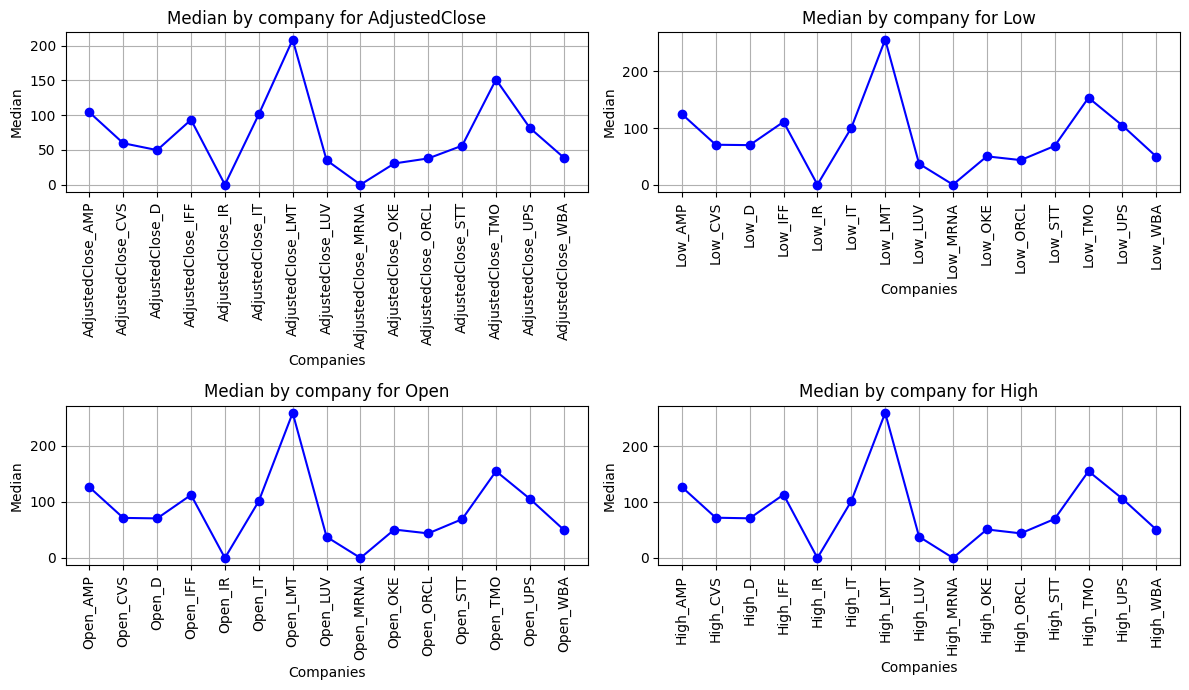

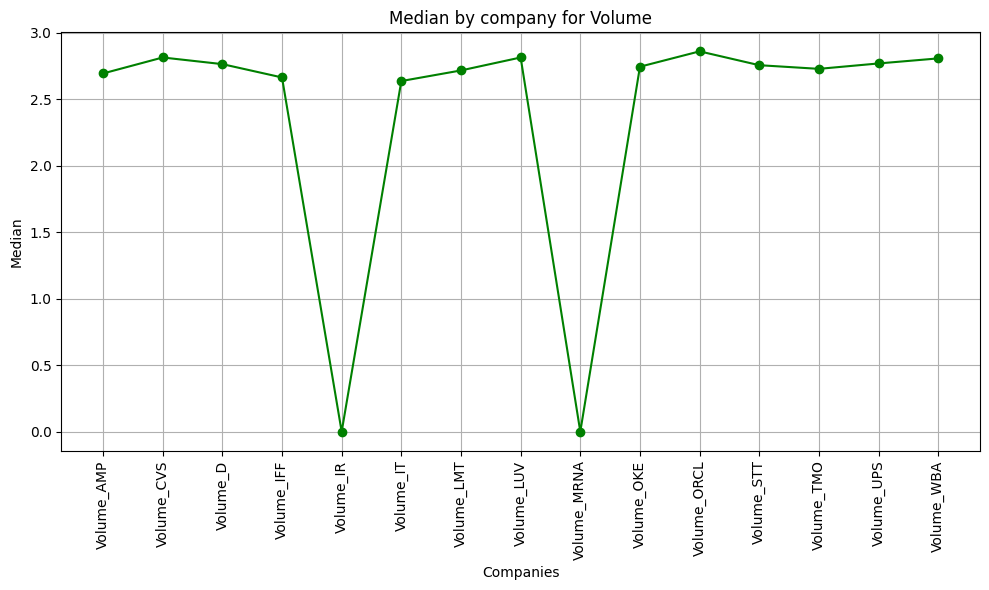

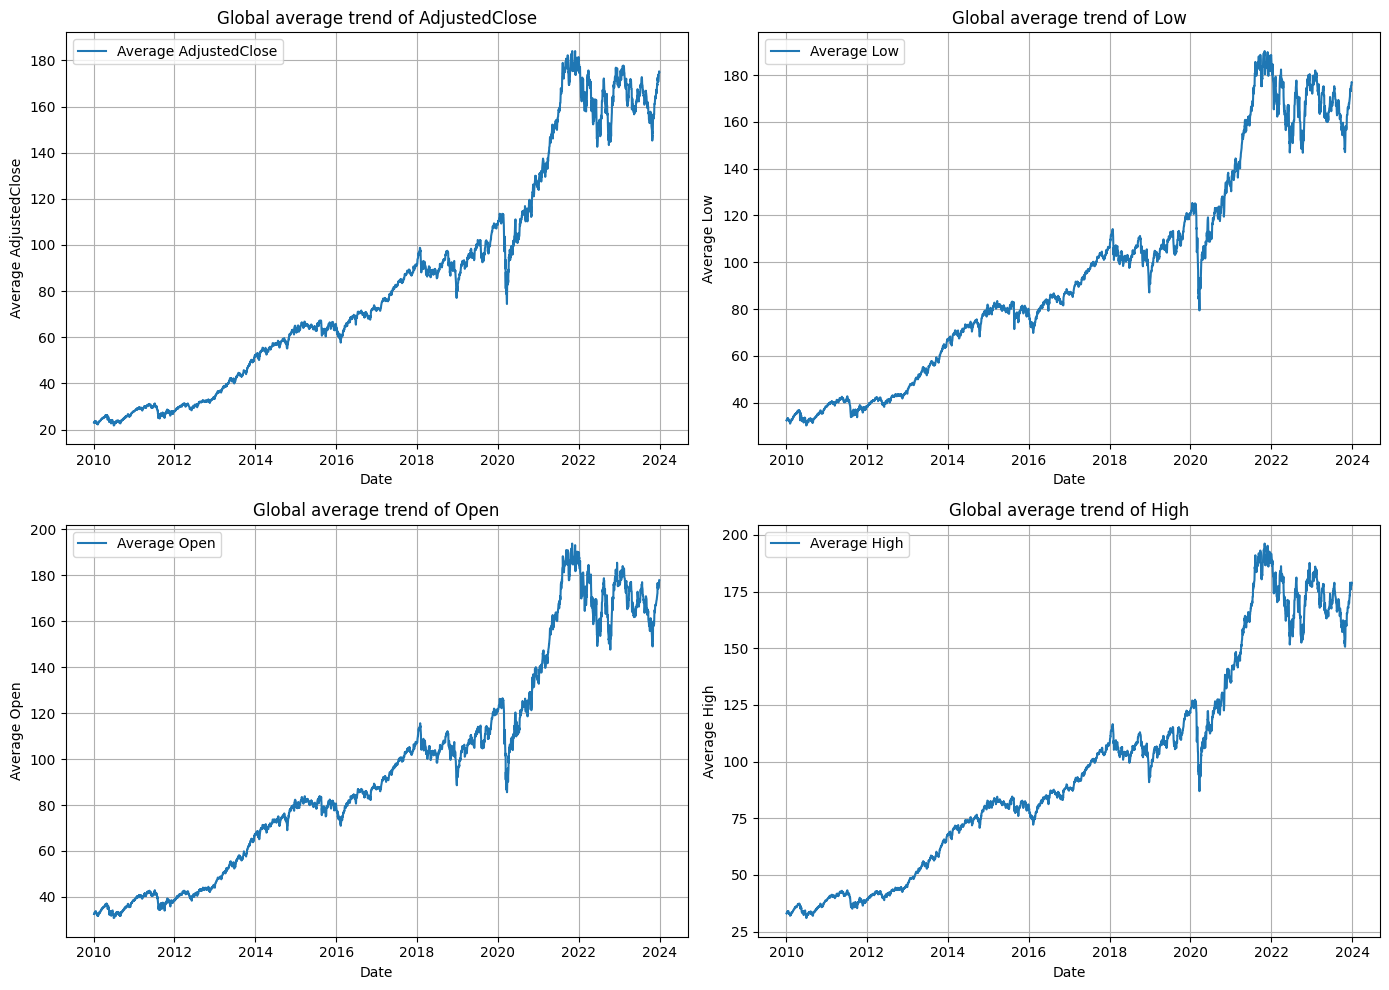

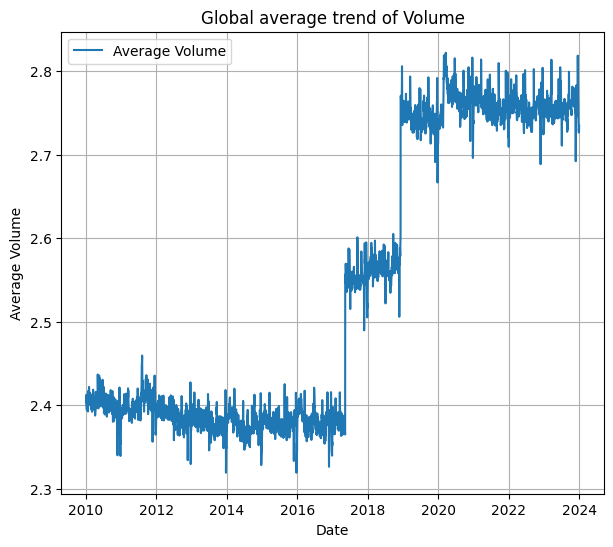

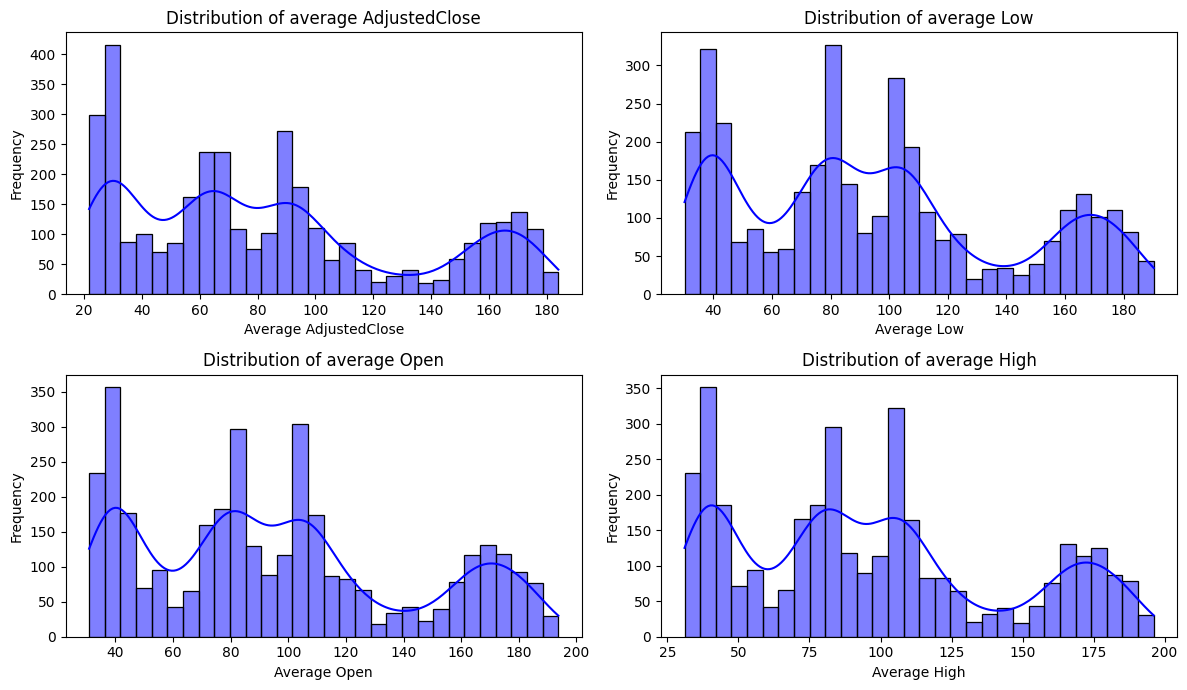

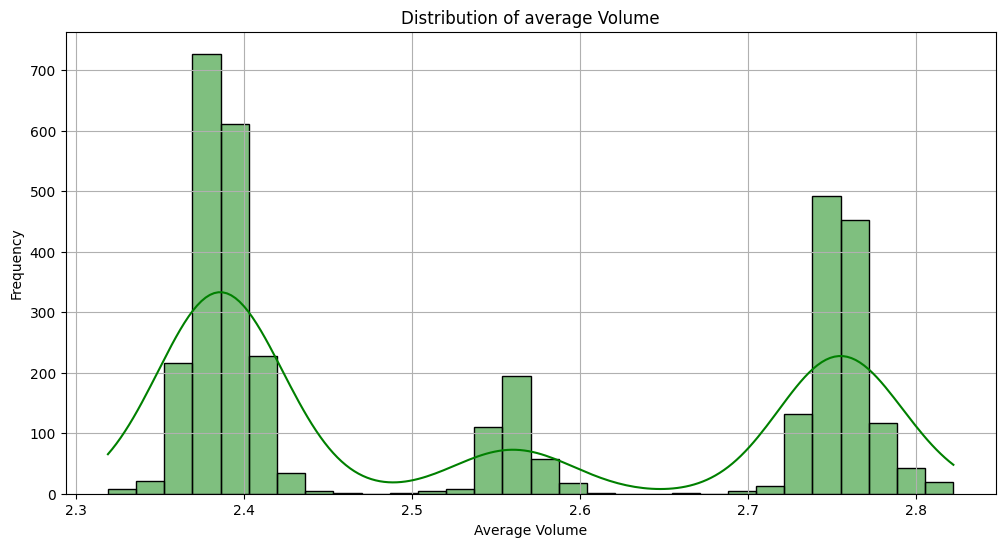

c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\Proyect2_LABIACD\visualizations.py:540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Filtrar columnas de indicadores técnicos


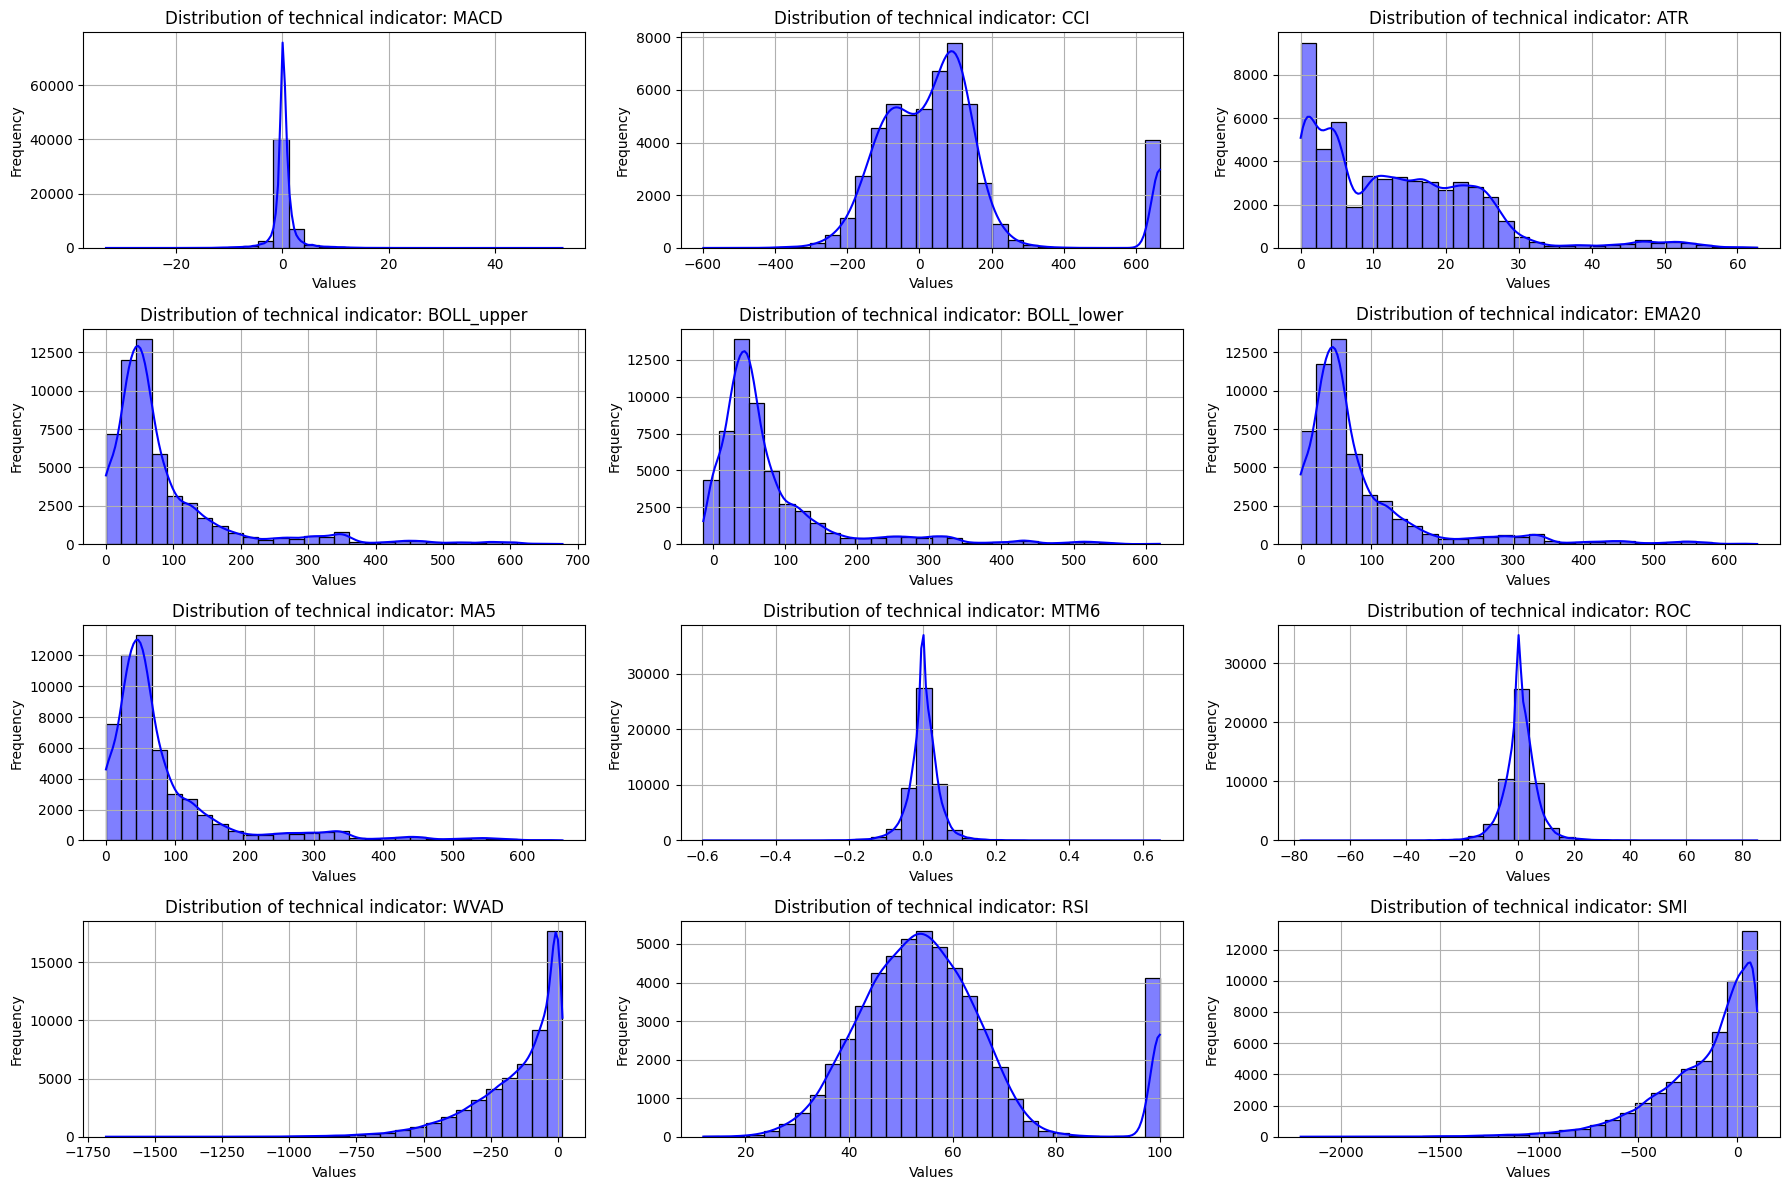

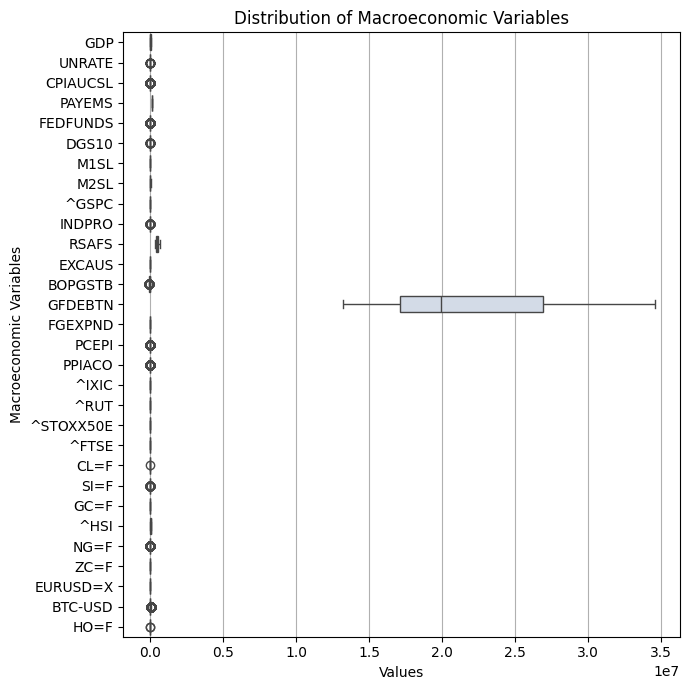

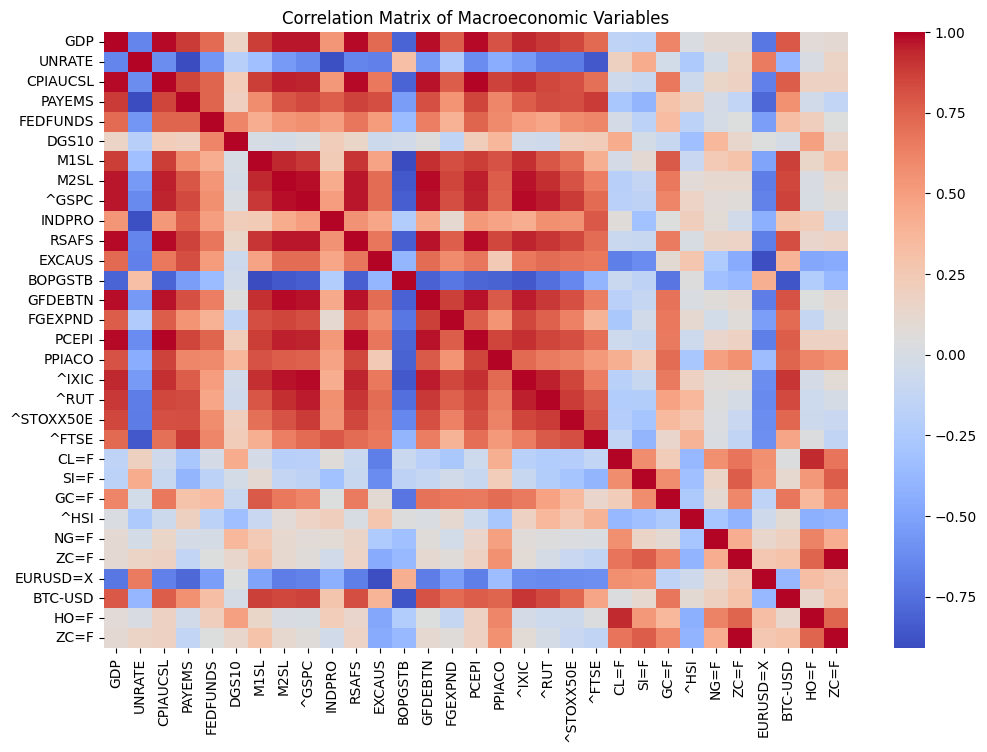

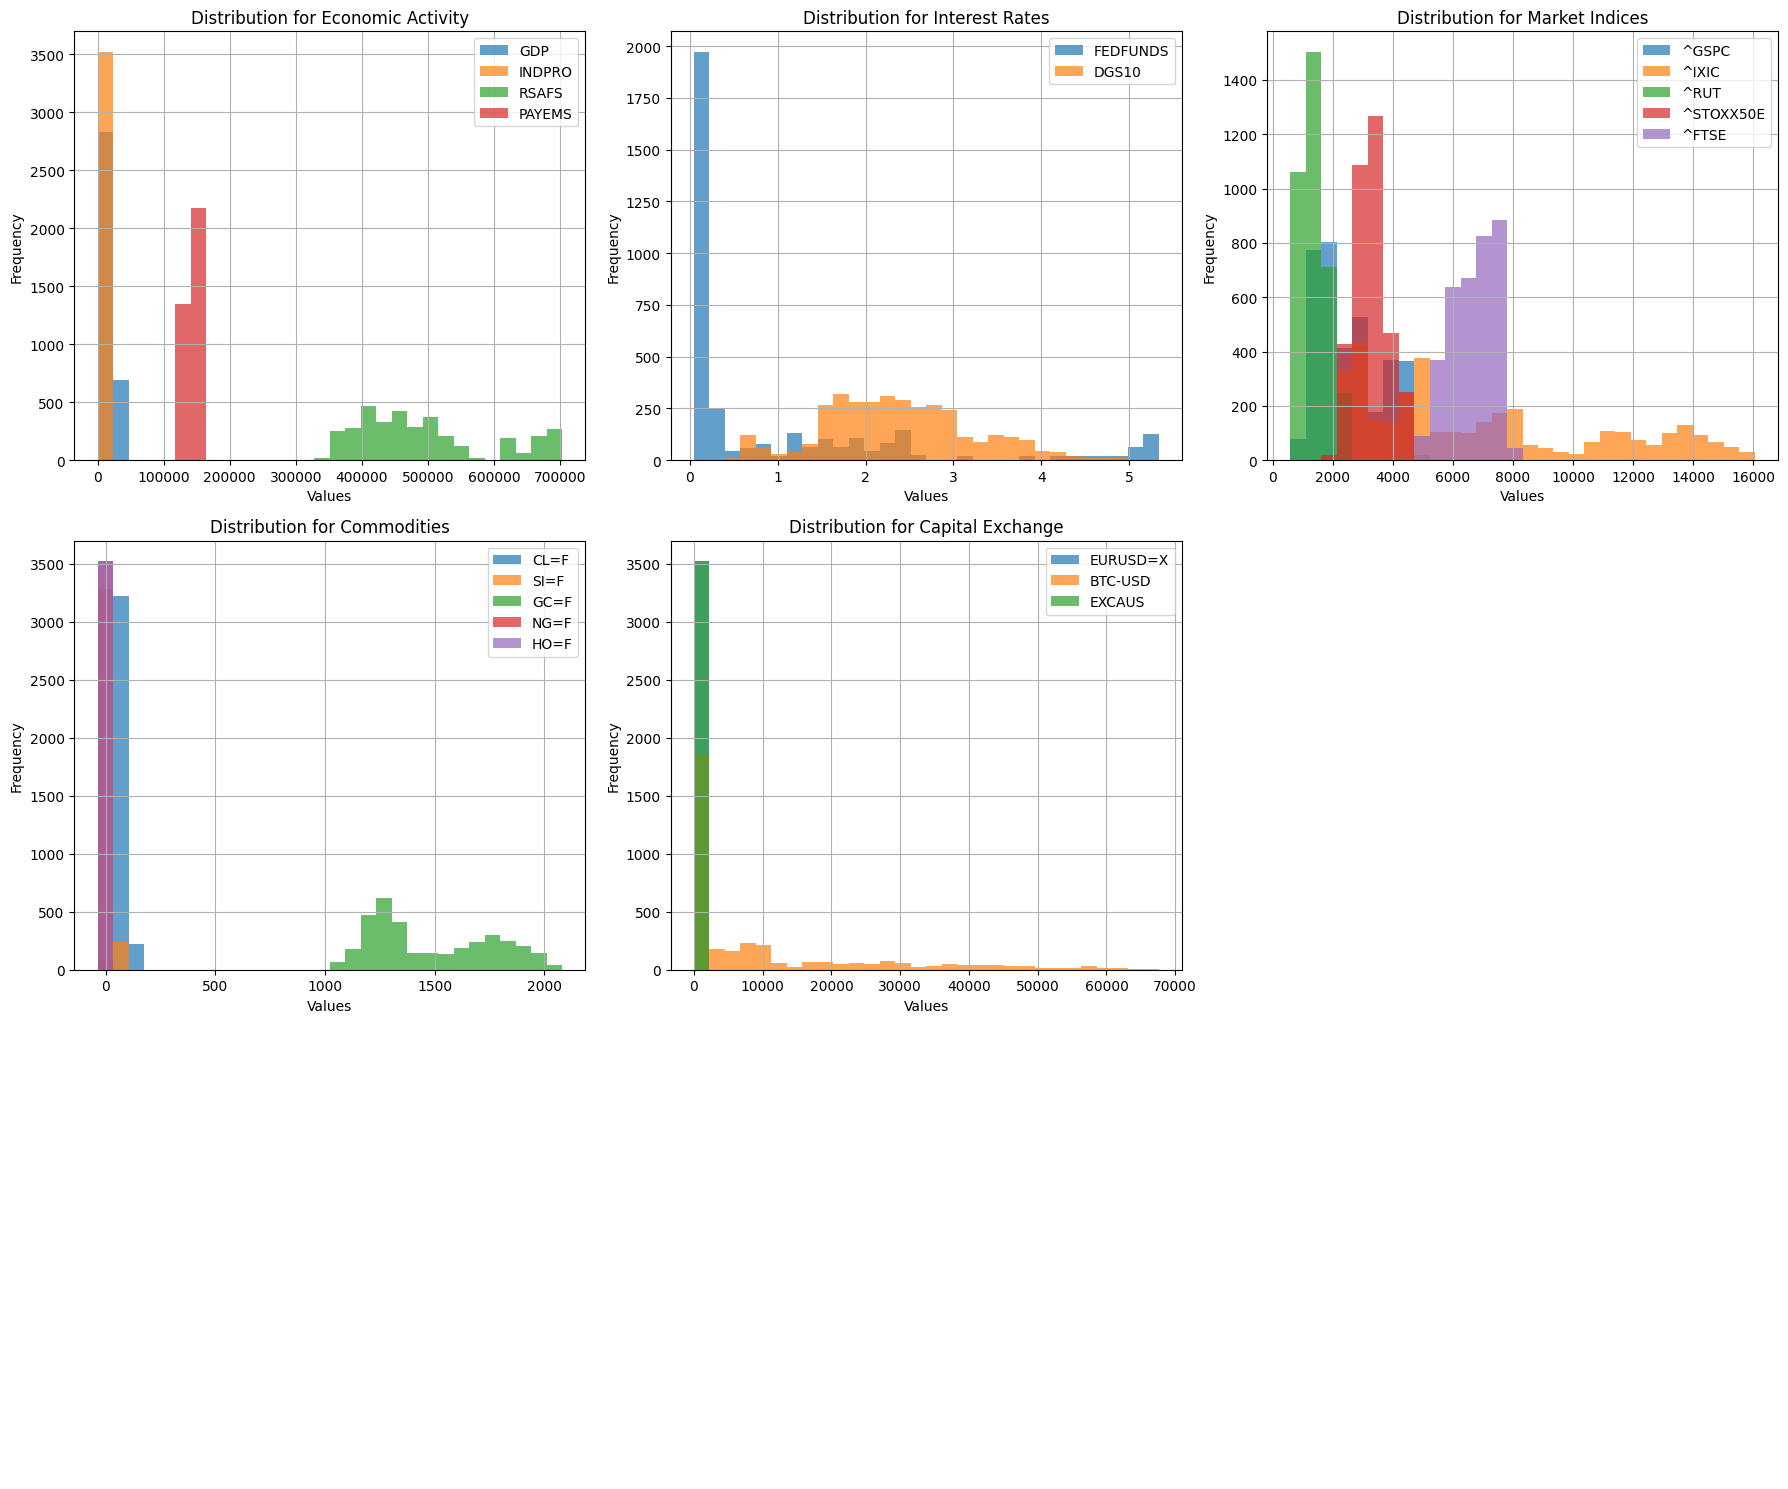

In [63]:

import visualizations
reload(visualizations)
from visualizations import analyze_financial_data

# Cargar datos

analyze_financial_data(train)

#### **Principal Components Analysis**

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a smaller set of uncorrelated variables called principal components. It retains most of the original data's variability while reducing redundancy and multicollinearity. PCA is particularly useful in high-dimensional datasets, as it significantly reduces computational costs and enhances model efficiency by simplifying the input data without sacrificing critical information. 

The steps involved include:

1. Standardization: Features are normalized to have a mean of 0 and standard deviation of 1, ensuring they contribute equally to the analysis.

2. Covariance Matrix: A matrix is computed to capture the relationships (covariance) between all features.

3. Decomposition: The covariance matrix is decomposed into eigenvalues and eigenvectors. Eigenvectors represent directions of maximum variance (principal components), while eigenvalues measure the magnitude of variance in those directions.

4. Selecting Principal Components: Components are ranked by eigenvalues, and the top components explaining the desired variance , in our case we selected those who explained 97.5% of the variance. 

After doing the previous steps we calculated the **Kaiser's criterion**. It is a method used to determine the number of principal components to retain. According to this criterion, only components with eigenvalues greater than 1 are selected. The rationale is that an eigenvalue represents the amount of variance explained by a component, and values greater than 1 indicate that the component explains more variance than an individual original feature. We applied in two ways, covariance-based and correlation-based matrices. Finally inside ``preprocess_and_pca`` we opted to calculate  ``X_train`` and `X_test` with the number of components which sastified the correlation based matrices, **473** components


Starting preprocessing and PCA...
Time before PCA: 20:21:21.287388
Number of components according to Kaiser criterion (covariance): 5
Number of components according to Kaiser criterion (correlation): 10
Time after PCA: 20:21:22.240271


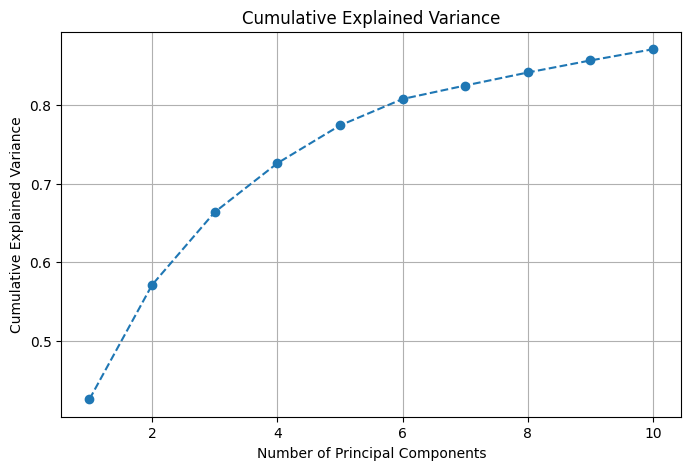

In [22]:
reload(utils)
from utils import preprocess_and_pca


cols_close = [col for col in train.columns if "Close" in col ]+ ['Date']
cols_adjusted = [col for col in cols_close if "Adjusted" in col]

# Separar características y etiquetas
X_train = train.drop(columns=cols_close)  # Eliminar todas las columnas que contienen "Close"
X_test = test.drop(columns=cols_close)


# Para y_train y y_test, nos  con "AdjustedClose" y "Date"
y_train = train[cols_adjusted]
y_test = test[cols_adjusted]


# Aplicar la función con tus datos
X_train, X_test, varianza_acumulada = preprocess_and_pca(X_train, X_test)


## Forecasting Model 

### **Model Selection** 

After performing Principal Component Analysis (PCA), the next step involves comparing various machine learning models to determine which one performs best on the dataset. In this initial phase, no hyperparameter tuning will be conducted to ensure a fair and quick evaluation of the models based purely on their baseline performance. Once the most promising model is identified, we will proceed with hyperparameter optimization to refine its predictive capabilities. This refined model will then be used to assess its ability to handle the given dataset and determine its feasibility for forecasting or classification tasks within our specific context. By systematically evaluating and optimizing these models, we aim to determine whether machine learning models can effectively address the forecasting challenges posed by the dataset.

The metrics selected for comparing the models are:

#### **Metrics for forecasting** 

##### 1. **Mean Absolute Error (MAE)**

MAE measures the average magnitude of the absolute errors between predictions ($y_{\text{pred}}$) and actual values ($y_{\text{true}}$).
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_{\text{true}, i} - y_{\text{pred}, i} \right|
$$
Where:
- $n$: Number of data points.
- $y_{\text{true}, i}$: Actual value for observation $i$.
- $y_{\text{pred}, i}$: Predicted value for observation $i$. 
**Interpretation:**  
A lower MAE indicates better model performance. It is scale-dependent and does not consider the direction of errors (over- or under-prediction).
##### 2. **Root Mean Squared Error (RMSE)**

RMSE is the square root of the average squared differences between predicted and actual values, penalizing larger errors more than MAE.

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_{\text{true}, i} - y_{\text{pred}, i} \right)^2}
$$

**Interpretation:**  
Similar to MAE but more sensitive to large deviations or outliers. A lower RMSE signifies better accuracy.

##### 3. **R-squared (R²)**

R², or the coefficient of determination, quantifies the proportion of the variance in the dependent variable explained by the independent variables.

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} \left( y_{\text{true}, i} - y_{\text{pred}, i} \right)^2}{\sum_{i=1}^{n} \left( y_{\text{true}, i} - \bar{y}_{\text{true}} \right)^2}
$$

Where:
- $\bar{y}_{\text{true}}$: Mean of the actual values.

**Interpretation:**  
- $R^2 = 1$: Perfect prediction.
- $R^2 = 0$: Predictions are as good as using the mean of the actual values.
- $R^2 < 0$: Model performs worse than simply predicting the mean.

##### 4. **Mean Absolute Percentage Error (MAPE)**

MAPE calculates the average percentage error between predicted and actual values, offering a scale-independent interpretation.

$$
\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_{\text{true}, i} - y_{\text{pred}, i}}{y_{\text{true}, i}} \right|
$$

**Interpretation:**  
Expressed as a percentage, MAPE provides intuitive interpretability. However, it can become undefined if any $y_{\text{true}, i} = 0$.


Modelo: KNN, Tiempo de ejecución: 0.01s
Modelo: LinearRegression, Tiempo de ejecución: 0.01s
Modelo: DecisionTree, Tiempo de ejecución: 0.03s
Modelo: SVR, Tiempo de ejecución: 0.51s
Modelo: Bagging, Tiempo de ejecución: 1.08s
0:	learn: 40.2755524	total: 3.17ms	remaining: 156ms
1:	learn: 39.1841996	total: 6.31ms	remaining: 151ms
2:	learn: 38.2115711	total: 9.01ms	remaining: 141ms
3:	learn: 37.2343006	total: 11.8ms	remaining: 136ms
4:	learn: 36.2739514	total: 14.3ms	remaining: 129ms
5:	learn: 35.3204328	total: 16.9ms	remaining: 124ms
6:	learn: 34.3937377	total: 19.6ms	remaining: 121ms
7:	learn: 33.5413758	total: 22.3ms	remaining: 117ms
8:	learn: 32.7149037	total: 25.4ms	remaining: 116ms
9:	learn: 31.8892720	total: 28.6ms	remaining: 115ms
10:	learn: 31.1148045	total: 32.5ms	remaining: 115ms
11:	learn: 30.3274489	total: 35.6ms	remaining: 113ms
12:	learn: 29.5362565	total: 39.2ms	remaining: 112ms
13:	learn: 28.8017149	total: 42.8ms	remaining: 110ms
14:	learn: 28.0991795	total: 46.3ms	remain

,MAE,RMSE,R2,MAPE
LightGBM,3.537404,4.978995,-0.994495,0.03162
XGBoost,3.574197,5.166007,-0.768333,0.030812
GradientBoosting,3.985025,5.534188,-0.749747,0.032918
Bagging,4.009619,5.827288,-1.05734,0.033731
DecisionTree,4.908664,7.009722,-2.698415,0.044312
RandomForest,5.950515,7.616312,-6.090539,0.05864
KNN,5.81148,7.958377,-6.394443,0.055134
AdaBoost,7.327409,10.3351,-3.586717,0.056451
LinearRegression,8.399767,10.365531,-6.998566,0.075393
SVR,12.679511,18.272458,-11.899527,0.093454


Using linear scale for R² due to negative or zero values.


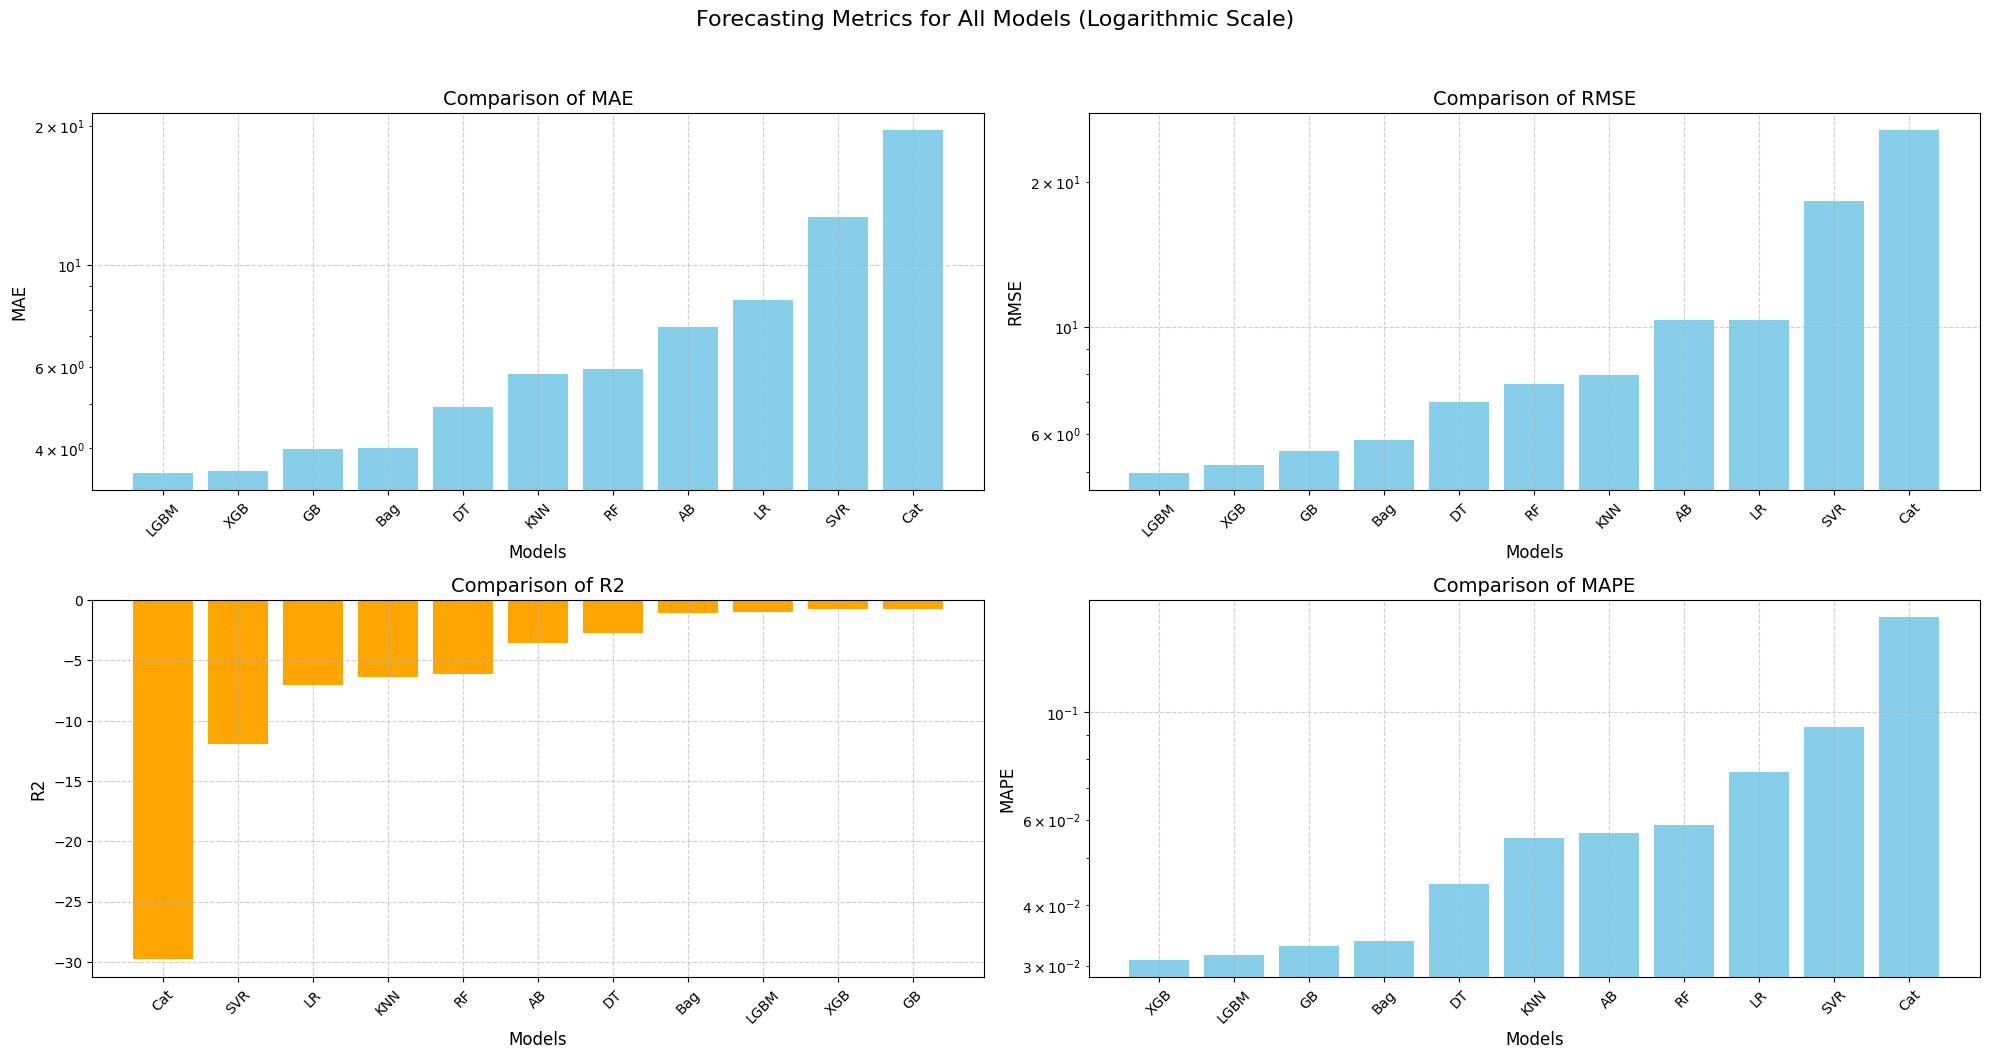

In [ ]:

metrics = {
    'MAE': [],
    'RMSE': [],
    'R2': [],
    'MAPE': []
}

models = {
    'KNN': MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5, n_jobs=1)),
    'LinearRegression': MultiOutputRegressor(LinearRegression(n_jobs=1)),
    'DecisionTree': MultiOutputRegressor(DecisionTreeRegressor(max_depth=4)),
    'SVR': MultiOutputRegressor(SVR(C=0.5)),
    'Bagging': MultiOutputRegressor(BaggingRegressor(n_jobs=1, n_estimators=20)),
    'CatBoost': CatBoostRegressor(thread_count=1, loss_function='MultiRMSE', depth=4, iterations=50),
    'XGBoost': XGBRegressor(n_jobs=1, objective='reg:squarederror', max_depth=4, n_estimators=50),
    'LightGBM': MultiOutputRegressor(LGBMRegressor(n_jobs=1, objective='regression_l2')),
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_jobs=1, max_depth=5, n_estimators=50)),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(max_depth=5, n_estimators=50)),
    'AdaBoost': MultiOutputRegressor(AdaBoostRegressor(n_estimators=50))
}

abbreviations = {
    'RandomForest': 'RF',
    'GradientBoosting': 'GB',
    'AdaBoost': 'AB',
    'KNN': 'KNN',
    'LinearRegression': 'LR',
    'DecisionTree': 'DT',
    'SVR': 'SVR',
    'Bagging': 'Bag',
    'CatBoost': 'Cat',
    'XGBoost': 'XGB',
    'LightGBM': 'LGBM',
                }

metrics_df = pd.DataFrame(columns=metrics, index=models.keys())

# Entrenar y evaluar cada modelo
for name, model in models.items():
    start_time = time.time()

    # Entrenar el modelo directamente en los datos de entrenamiento
    model.fit(X_train, y_train)

    # Hacer predicciones en los datos de prueba
    predictions = model.predict(X_test)

    # Calcular métricas
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)

    # Guardar métricas
    metrics_df.loc[name] = [mae, rmse, r2, mape]

    # Registrar tiempo de ejecución
    execution_time = time.time() - start_time
    print(f"Modelo: {name}, Tiempo de ejecución: {execution_time:.2f}s")

# Ordenar y mostrar resultados
metrics_df.sort_values(by=['RMSE', 'MAPE'], ascending=True, inplace=True)
display(metrics_df)

metrics_df_sorted = metrics_df.sort_values(by='RMSE', ascending=True)

metrics_df.rename(index=abbreviations, inplace=True)

# Crear una figura con subplots organizados en una cuadrícula
fig, axes = plt.subplots(3, 2, figsize=(20, 15))  # Ajustar el tamaño según las necesidades
axes = axes.flatten()  # Aplanar los ejes para facilitar la iteración
fig.suptitle('Forecasting Metrics for All Models', fontsize=16)

# Iterar sobre las métricas para graficar en cada subplot
for i, metric in enumerate(metrics_df.columns):
    ax = axes[i]  # Seleccionar el subplot correspondiente
    
    # Ordenar métricas de forma ascendente
    sorted_metric = metrics_df[metric].sort_values(ascending=True)
    
    if metric == 'R2' and (sorted_metric <= 0).any():
        print("Using linear scale for R² due to negative or zero values.")
        ax.bar(sorted_metric.index, sorted_metric, color='orange')
        ax.set_yscale('linear')  # Cambiar a escala lineal para R²
    else:
        ax.bar(sorted_metric.index, sorted_metric, color='skyblue')
        ax.set_yscale('log')  # Mantener escala logarítmica para otros

    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'Comparison of {metric}', fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)

# Eliminar subplots vacíos si hay más subplots que métricas
for j in range(len(metrics_df.columns), len(axes)):
    fig.delaxes(axes[j])  # Eliminar ejes innecesarios

# Ajustar diseño y guardar la figura
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar espacio para el título general
plt.savefig('plots/metrics_comparison_log_scale.png')
plt.show()




# **Final prediction**


Finally we choose for the hyperparameter tuning and final prediction the following models :  

- ``LinearRegression``
- ``XGBoost``
- ``LightGBM``

Now we will implement ``Randomized Search Cross Validation`` with a total number of Time Series Splits of **5**. The tecnique involved for splitting the data is explained graphically below: 


<img src="images/time_series_split.png" style="width:50%; height:50%;">

In [23]:
# Definir las métricas
metrics = {
    'MAE': [],
    'RMSE': [],
    'R2': [],
    'MAPE': []
}

# Definir modelos con espacios de búsqueda de hiperparámetros
models = {
    
    'LinearRegression': (MultiOutputRegressor(LinearRegression()), {
        'estimator__fit_intercept': [True, False]
    }),
    'XGBoost': (XGBRegressor(objective='reg:squarederror', n_jobs=1), {
        'max_depth': [3, 5, 10],
        'n_estimators': [10, 50, 100],
        'learning_rate': [0.01, 0.1, 0.3]
    }),
    'LightGBM': (MultiOutputRegressor(LGBMRegressor()), {
        'estimator__num_leaves': [10, 20, 30],
        'estimator__learning_rate': [0.01, 0.1, 0.3],
        'estimator__n_estimators': [10, 50, 100]
    }),
}

metrics_df = pd.DataFrame(columns=metrics, index=models.keys())

# Crear TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

best_models = {}
execution_times = {}

# Iterar sobre los modelos
for name, (model, param_grid) in models.items():
    start_time = time.time()
    print(f"Searching hyperparameters for {name}...")

    # Realizar RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    search.fit(X_train, y_train)

    # Guardar el mejor modelo
    best_model = search.best_estimator_
    best_models[name] = best_model

    # Imprimir mejores hiperparámetros
    print(f"Best parameters for {name}: {search.best_params_}")

    # Evaluar el modelo en los datos de prueba
    predictions = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)

    # Guardar métricas en el DataFrame
    metrics_df.loc[name] = [mae, rmse, r2, mape]

    # Guardar tiempo de ejecución
    execution_times[name] = time.time() - start_time
    print(f"Finished {name} in {execution_times[name]:.2f}s")

# Ordenar modelos por RMSE y mostrar resultados
metrics_df.sort_values(by='RMSE', inplace=True)
print("\nMetrics for all models:")
print(metrics_df)

# Seleccionar el mejor modelo
best_model_name = metrics_df.index[0]
best_model = best_models[best_model_name]
print(f"\nBest model: {best_model_name}")

# Entrenar el mejor modelo en todos los datos de entrenamiento
best_model.fit(X_train, y_train)

# Hacer predicciones con el mejor modelo en los datos de prueba
final_predictions = best_model.predict(X_test)

# Calcular métricas finales
final_mae = mean_absolute_error(y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_r2 = r2_score(y_test, final_predictions)
final_mape = mean_absolute_percentage_error(y_test, final_predictions)

print("\nFinal evaluation on test set:")
print(f"MAE: {final_mae:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"R2: {final_r2:.4f}")
print(f"MAPE: {final_mape:.4f}")

Searching hyperparameters for LinearRegression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for LinearRegression: {'estimator__fit_intercept': True}
Finished LinearRegression in 5.43s
Searching hyperparameters for XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for XGBoost: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}
Finished XGBoost in 13.06s
Searching hyperparameters for LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3522, number of used features: 10
[LightGBM] [Info] Start training from score 53.808757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data

<!-- Hay que hacer texto de resultados -->

# **3D Structure**

## **3D Transformation**

# ALEX

In [80]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


# Listado de empresas y columnas macroeconómicas
empresas = sorted(set(col.split('_')[-1] for col in train.columns if '_' in col))
empresas=empresas[:-1]
columnas_macro = [
    'GDP',
    'UNRATE',
    'CPIAUCSL',
    'PAYEMS',
    'FEDFUNDS',
    'DGS10',
    'M1SL',
    'M2SL',
    '^GSPC',
    'INDPRO',
    'RSAFS',
    'EXCAUS',
    'BOPGSTB',
    'GFDEBTN',
    'FGEXPND',
    'PCEPI',
    'PPIACO',
    '^IXIC',
    '^RUT',
    '^STOXX50E',
    '^FTSE',
    'CL=F',
    'SI=F',
    'GC=F',
    '^HSI',
    'NG=F',
    'ZC=F',
    'EURUSD=X',
    'BTC-USD',
    'HO=F',
    'ZC=F'
]

# Transformar conjuntos de entrenamiento y prueba
tensor_train = transformar_a_tensor_3d(train, empresas, columnas_macro)
tensor_test = transformar_a_tensor_3d(test, empresas, columnas_macro)

# # Guardar los tensores
np.save('tensor_train.npy', tensor_train)
np.save('tensor_test.npy', tensor_test)

# print("Tensores guardados exitosamente.")




Num Empresas 500
Num Fechas  3522
Num Características Empresa 19
Num Características Macro 31
Fecha actual 2010-01-04 00:00:00
Fecha actual 2010-01-05 00:00:00
Fecha actual 2010-01-06 00:00:00
Fecha actual 2010-01-07 00:00:00
Fecha actual 2010-01-08 00:00:00
Fecha actual 2010-01-11 00:00:00
Fecha actual 2010-01-12 00:00:00
Fecha actual 2010-01-13 00:00:00
Fecha actual 2010-01-14 00:00:00
Fecha actual 2010-01-15 00:00:00
Fecha actual 2010-01-19 00:00:00
Fecha actual 2010-01-20 00:00:00
Fecha actual 2010-01-21 00:00:00
Fecha actual 2010-01-22 00:00:00
Fecha actual 2010-01-25 00:00:00
Fecha actual 2010-01-26 00:00:00
Fecha actual 2010-01-27 00:00:00
Fecha actual 2010-01-28 00:00:00
Fecha actual 2010-01-29 00:00:00
Fecha actual 2010-02-01 00:00:00
Fecha actual 2010-02-02 00:00:00
Fecha actual 2010-02-03 00:00:00
Fecha actual 2010-02-04 00:00:00
Fecha actual 2010-02-05 00:00:00
Fecha actual 2010-02-08 00:00:00
Fecha actual 2010-02-09 00:00:00
Fecha actual 2010-02-10 00:00:00
Fecha actual 20

### Adapting Data for Deep Learning Models

In [83]:
ventana = 30  # Días de entrada
horizonte = 22  # Días a predecir

# Crear ventanas para entrenamiento y prueba
X_train, y_train = crear_ventanas_temporales(tensor_train, ventana=ventana, horizonte=horizonte)
X_test, y_test = crear_ventanas_temporales(tensor_test, ventana=5, horizonte=1)

print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)


# Aplanar X_train para ajustar el escalador
X_train_2d = X_train.reshape(-1, X_train.shape[-1])  # Aplanar: (n_samples * ventana * n_empresas, n_features)
scaler_X = StandardScaler()
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)

# Volver a la forma original
X_train = X_train_scaled_2d.reshape(X_train.shape)

# Escalar X_test con el mismo escalador
X_test_2d = X_test.reshape(-1, X_test.shape[-1])  # Aplanar
X_test_scaled_2d = scaler_X.transform(X_test_2d)
X_test = X_test_scaled_2d.reshape(X_test.shape)

# Ajustar escalador para y_train
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

# Escalar y_test con el mismo escalador
y_test= scaler_y.transform(y_test)

print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

# Convertir datos a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # (3472, 30, 100)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # (3472, 2)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # (16, 3, 100)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # (16, 2)

print("Forma de X_train:", X_train_tensor.shape)
print("Forma de y_train:", y_train_tensor.shape)
print("Forma de X_test:", X_test_tensor.shape)
print("Forma de y_test:", y_test_tensor.shape)

X_train_tensor = X_train_tensor.view(
    X_train_tensor.shape[0],  # batch_size
    X_train_tensor.shape[1],  # seq_length
    -1  # Flatten (n_companies * features_per_company)
)

X_test_tensor = X_test_tensor.view(
    X_test_tensor.shape[0], 
    X_test_tensor.shape[1], 
    -1
)

# Crear datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Forma de X_train: (3470, 30, 500, 50)
Forma de y_train: (3470, 500)
Forma de X_test: (14, 5, 500, 50)
Forma de y_test: (14, 500)
Forma de X_train: (3470, 30, 500, 50)
Forma de y_train: (3470, 500)
Forma de X_test: (14, 5, 500, 50)
Forma de y_test: (14, 500)


## **Long Short-Term Memory (LSTM)** 

Long Short-Term Memory (LSTM) networks are a powerful innovation within machine learning, specifically tailored for sequential data. They emerged to address the limitations of traditional Recurrent Neural Networks (RNNs), particularly the vanishing gradient problem. This issue hampers the ability of standard RNNs to retain important long-term information during training, which is crucial for understanding sequences that unfold over extended periods.

<div style="text-align: center;">
    <img src="images/lstm.jpg" style="width:25%; height:25%;" alt="LSTM Diagram">
</div>

### Core Components of LSTMs
- Input Gate: This mechanism determines what new data should be stored in the memory cell. It evaluates the incoming information and decides which elements are relevant to retain.
- Forget Gate: As its name suggests, this gate identifies and removes unnecessary or outdated information from the memory cell, allowing the model to prioritize more current and relevant data.
- Output Gate: This final gate regulates the output of information from the memory cell to either subsequent time steps or layers in the network, ensuring only meaningful insights are passed forward.

Why using LSTMs ?

- Temporal Dependencies: Stock prices often exhibit intricate patterns influenced by time. For instance, trends, cycles, and seasonal effects play a vital role in predicting future movements. LSTMs are designed to recognize these patterns by effectively connecting past and present data points.
- Handling Multivariate Data: Stock forecasting often requires analysis across multiple variables, such as individual stock prices, macroeconomic indicators, or global market trends. LSTMs can process such multidimensional data seamlessly, capturing relationships among variables that span across time.

Entrenando modelo LSTM con configuración 30_22_256_4_0.55_50_0.0001_1e-07_adam_MSE
Epoch 1/50, Train Loss: 0.7478, Valid Loss: 1.4927, Train RMSE: 0.8633, Valid RMSE: 1.2218, Train MAPE: 2.2880, Valid MAPE: 0.7712, Train MPE: 0.3405, Valid MPE: 0.1299, Train R²: 0.2546, Valid R²: -362.3265
Epoch 2/50, Train Loss: 0.6658, Valid Loss: 1.3577, Train RMSE: 0.8148, Valid RMSE: 1.1652, Train MAPE: 5.2817, Valid MAPE: 0.7739, Train MPE: 0.2760, Valid MPE: 0.1371, Train R²: 0.3360, Valid R²: -330.3358
Epoch 3/50, Train Loss: 0.4466, Valid Loss: 1.3609, Train RMSE: 0.6664, Valid RMSE: 1.1666, Train MAPE: 3.4609, Valid MAPE: 0.7826, Train MPE: 0.2664, Valid MPE: 0.1409, Train R²: 0.5559, Valid R²: -333.6782
Epoch 4/50, Train Loss: 0.3256, Valid Loss: 1.1335, Train RMSE: 0.5685, Valid RMSE: 1.0647, Train MAPE: 2.9199, Valid MAPE: 0.7753, Train MPE: 0.2049, Valid MPE: 0.1707, Train R²: 0.6769, Valid R²: -290.8592
Epoch 5/50, Train Loss: 0.3248, Valid Loss: 1.1732, Train RMSE: 0.5679, Valid RMSE: 1

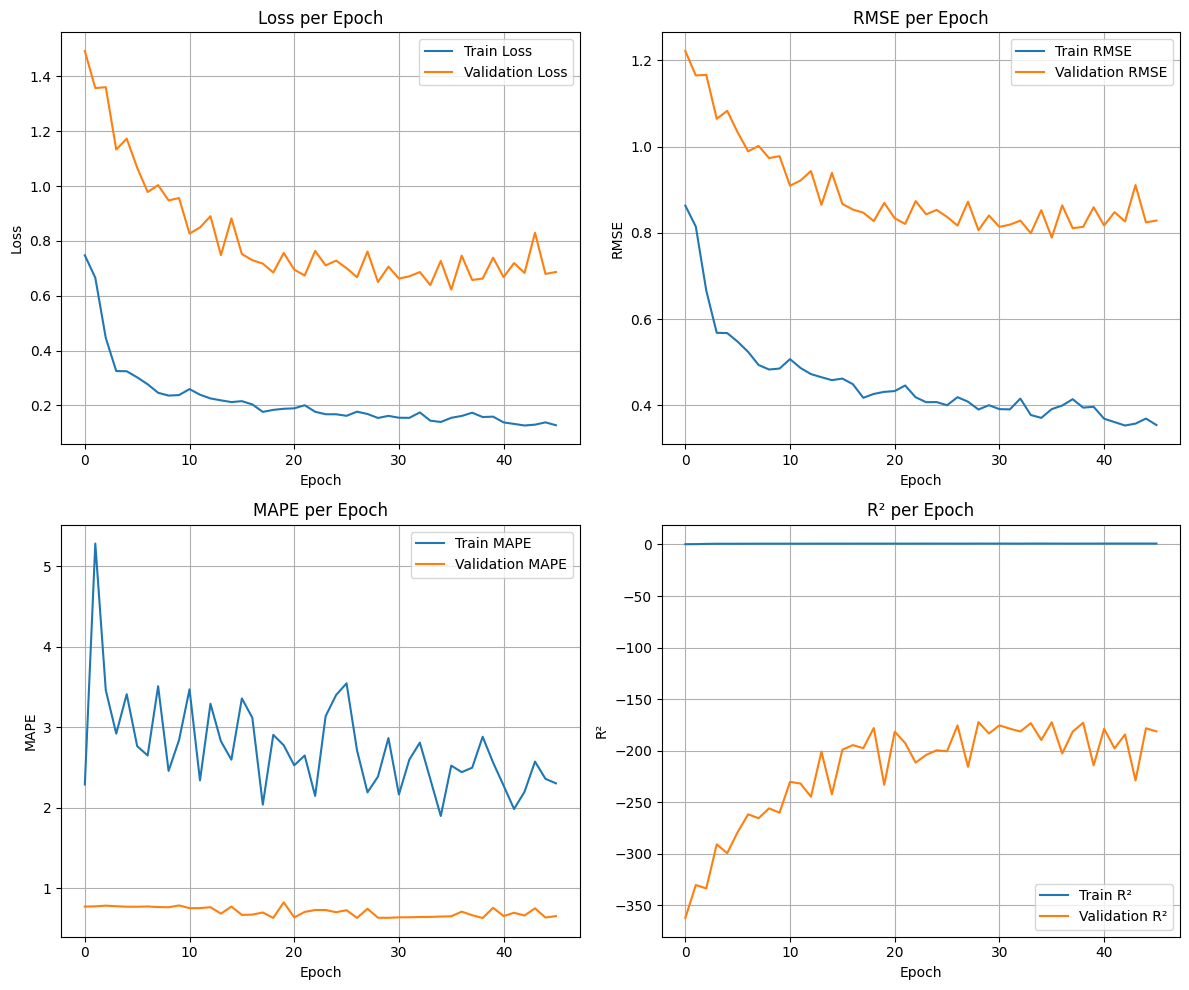

Base path: C:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\Proyect2_LABIACD\plots
Filename: prices_comparision\LSTM\50\30_22_256_4_0.55_50_0.0001_1e-07_adam_MSE.png
Save path: C:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\Proyect2_LABIACD\plots\prices_comparision\LSTM\50\30_22_256_4_0.55_50_0.0001_1e-07_adam_MSE.png


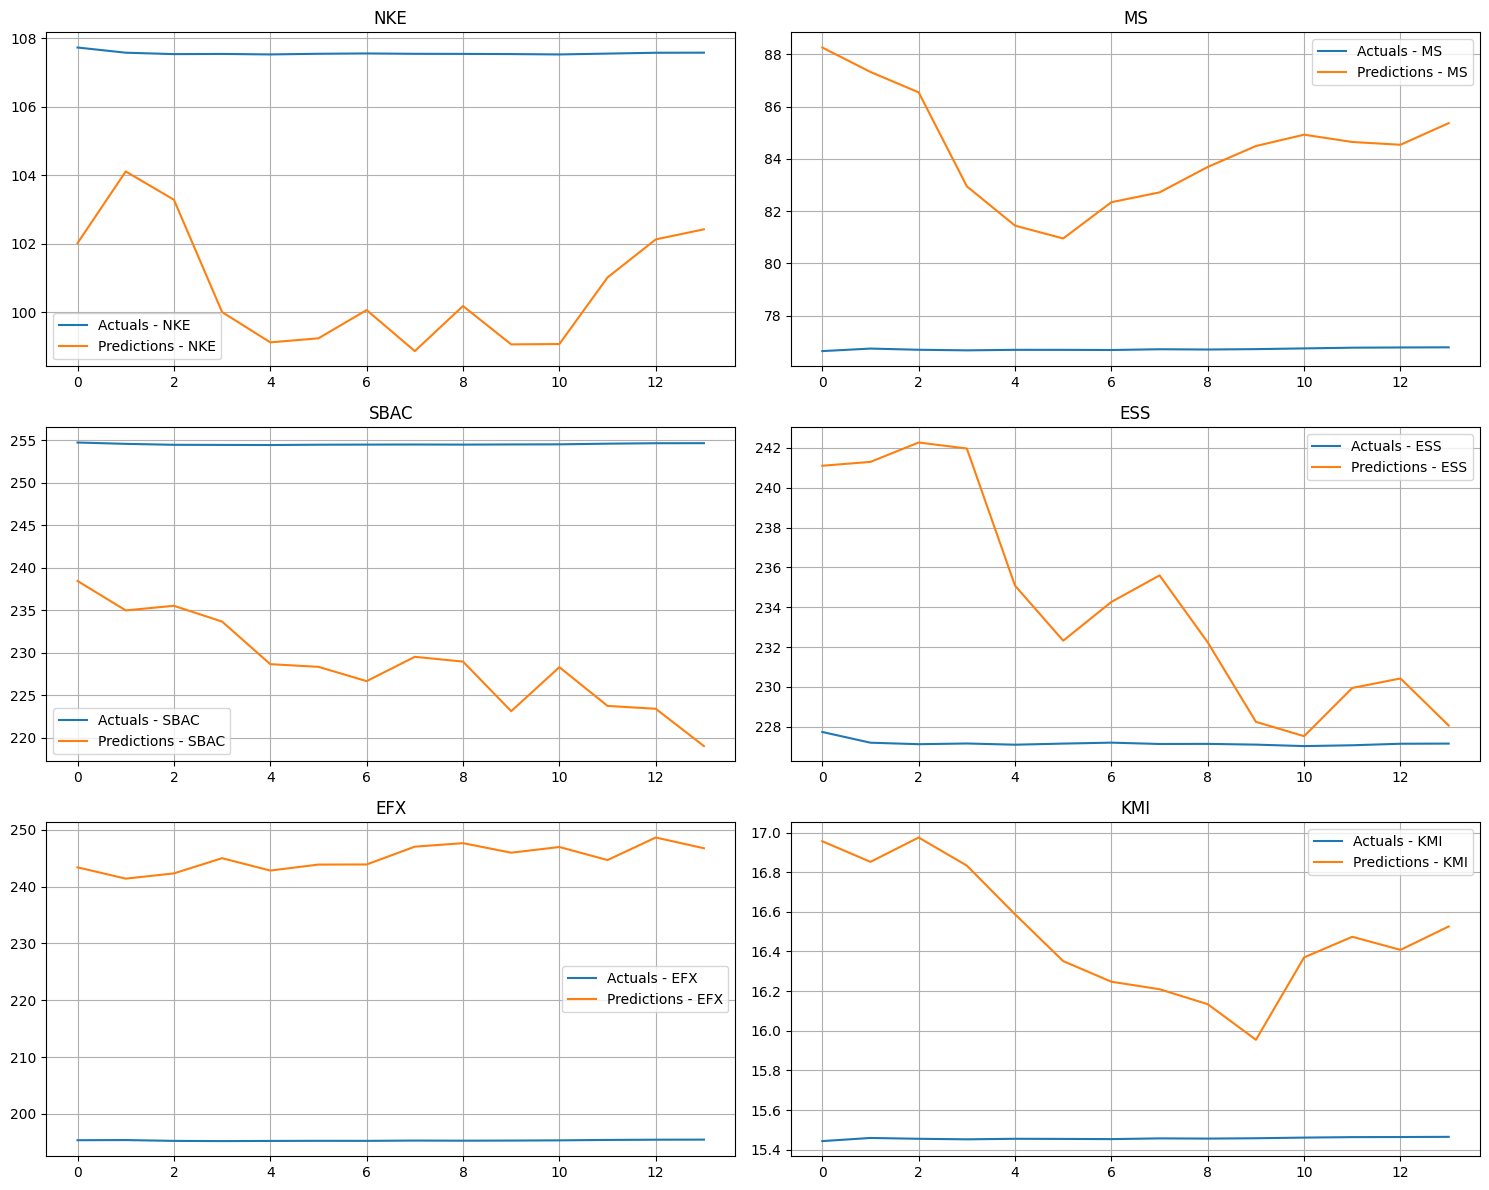

<Figure size 640x480 with 0 Axes>

Plot saved at C:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\LAB_IACD\Proyecto_2_Lab_IACD\Proyect2_LABIACD\plots\prices_comparision\LSTM\50\30_22_256_4_0.55_50_0.0001_1e-07_adam_MSE.png


In [54]:
import models, visualizations,utils
reload(models)
reload(visualizations)
reload(utils)

from models import LSTMModel, train_and_evaluate_model
from visualizations import plot_prices_comparision, plot_metrics
from utils import get_company_list_from_directory,map_company_names_to_predictions, desescalar_y


directory = "data/stocks"  # Replace with your actual directory path
companies = get_company_list_from_directory(directory)


# Entrenar el modelo LSTM Configuración buena 
input_size      = X_train_tensor.shape[2]  # Número de características de entrada
output_size     = y_train.shape[1]        # Número de empresas (salida)


ventana=30
horizonte=22
hidden_size = 512
num_layers = 3
dropout_prob = 0.75
num_epochs = 50
learning_rate = 5e-5
weight_decay = 1e-8
optimizer_choice = 'adam'
critierion='MSE'
patience=10


model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers,
    dropout_prob=dropout_prob,

)
file_name = f"{ventana}_{horizonte}_{hidden_size}_{num_layers}_{dropout_prob}_{num_epochs}_{learning_rate}_{weight_decay}_{optimizer_choice}_{critierion}"

print(f"Entrenando modelo LSTM con configuración {file_name}")
# train_model(model_lstm, train_loader, test_loader, num_epochs, learning_rate)
# lstm_preds, lstm_actuals = evaluate_model(model_lstm, test_loader)

trained_model, preds, actuals,metrics = train_and_evaluate_model(
    model, train_loader, test_loader, num_epochs, learning_rate,weight_decay,optimizer_choice,critierion,patience
)

actuals_deescalados,predicciones_deescaladas = desescalar_y(actuals,preds,scaler_y)
# Guardar predicciones con Pickle
with open('lstm_preds.pkl', 'wb') as f:
    pickle.dump(predicciones_deescaladas, f)

plot_metrics(metrics,'LSTM',str(len(companies)),guardar=False,file_name=file_name)
plot_prices_comparision(actuals,preds,'LSTM',scaler_y,len(companies),companies,guardar=False,file_name=file_name)




# **Bibliograpghy**

- Wong, Albert, et al. “Short-Term Stock Price Forecasting Using Exogenous Variables and Machine Learning Algorithms.” ArXiv.org, 2023, arxiv.org/abs/2309.00618. Accessed 7 Dec. 2024.
- Gabriel, and Marcel Otoboni. “Previs\~Ao Dos Pre\C{C}Os de Abertura, M\'Inima E M\'Axima de \'Indices de Mercados Financeiros Usando a Associa\C{C}\~Ao de Redes Neurais LSTM.” ArXiv.org, 2021, arxiv.org/abs/2108.10065. Accessed 7 Dec. 2024.
- Orsel, Ogulcan E., and Sasha S. Yamada. “Comparative Study of Machine Learning Models for Stock Price Prediction.” ArXiv.org, 31 Jan. 2022, arxiv.org/abs/2202.03156.
- Bao W, Yue J, Rao Y. A deep learning framework for financial time series using stacked autoencoders and long-short term memory. PLoS One. 2017 Jul 14;12(7):e0180944. doi: 10.1371/journal.pone.0180944. PMID: 28708865; PMCID: PMC5510866.